<a href="https://colab.research.google.com/github/peeyushsinghal/da/blob/main/mitigating_bias_sa_da_v31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes : 



*   changing optimizer to AdamW
*   included ReduceLROnPlateau


2.   changing optimizer to AdamW



# Mitigating bias in sentiment analysis using domain adaptation

In [112]:
! pip install torchtext==0.10.0 --quiet # DOWNGRADE YOUR TORCHTEXT
! pip install ekphrasis --quiet # library to pre process twitter data
! pip install emoji --upgrade --quiet #library to deal with emoji data
# ! pip install torch-lr-finder # library to find LR 

In [113]:
## Import statements
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.legacy.data import Dataset, Field, TabularDataset, BucketIterator
from torchtext.vocab import GloVe
import torchtext.vocab as vocab
import numpy as np
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import emoji
from torchtext.legacy.vocab import Vectors
from tqdm import tqdm
import random
import torch.optim as optim
import scipy.stats as stats
from statistics import mean

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

import time

from copy import deepcopy

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import matplotlib.pyplot as plt
# import EarlyStopping
# from pytorchtools import EarlyStopping

# from torch_lr_finder import LRFinder


from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [114]:
# checking device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:{}".format(DEVICE))

Running on:cuda


## Data loading

In [115]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Configuration

In [116]:

BASE_PATH = '/content/drive/MyDrive/semeval-2018'

DATA_DIR = os.path.join(BASE_PATH,'datasets')
TARGET_DIR = os.path.join(BASE_PATH,'targetdataset')

MODEL_DIR = os.path.join(BASE_PATH,'models')
REF_DIR = os.path.join(BASE_PATH,'reference')
EMBEDDINGS_DIR = os.path.join(BASE_PATH,'embeddings')

MAX_SIZE = 50
MAX_VOCAB_SIZE = 10000

# BATCH_SIZE = 8
# BATCH_SIZE = 32
BATCH_SIZE = 16 # based on EWC paper

EMBEDDING_TO_BE_USED = 'glove_gn' # {'glove', 'glove_gn'}
TARGET_BATCH_SIZE = 8

NUM_EPOCHS = 100
# NUM_EPOCHS = 2
# NUM_EPOCHS = 30
# NUM_EPOCHS = 60
INITIAL_LR = 0.001
# INITIAL_LR_EWC = INITIAL_LR / NUM_EPOCHS
LR_GAMMA = 0.9
LR = 2e-4

from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau,ExponentialLR


PATIENCE = 10
EWC_LAMBDA = 0.4

if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
  print("The new directory is created!")


BONFERRONI_CORRECTION = 5.0

In [117]:
# Seed and Cuda

# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


In [118]:
# data configuration

class TASK1(object):
  
    EI_reg = {
        'anger': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-anger-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-anger-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-anger-test-gold.txt')
                },
        'joy': {
                'train': os.path.join(
                    DATA_DIR, 'task1/EI-reg/training/EI-reg-En-joy-train.txt'),
                'dev': os.path.join(
                    DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-joy-dev.txt'),
                'gold': os.path.join(
                    DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-joy-test-gold.txt')
                },
        'fear': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-fear-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-fear-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-fear-test-gold.txt')
                },
        'sadness': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-sadness-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-sadness-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-sadness-test-gold.txt')
                }                     
        }

    V_reg = {
        'train': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-train.txt'),
        'dev': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-dev.txt'),
        'gold': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-test-gold.txt')
             }

    EEC = {
        'eec': os.path.join(
            DATA_DIR, 'task1/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')
             }

## Source Data
Parsing Emotion and Valence regression data : `format [ID	Tweet	Affect Dimension	Intensity Score]`

In [119]:
def parse_reg(data_file, label_format='tuple'):
    """
    This is for datasets for the EI-reg and V-reg English tasks 
    Returns:
        df: dataframe with columns in the first row of file [ID-Tweet-Affect Dimension-Intensity Score]
    """
    with open(data_file, 'r') as fd:
      data = [l.strip().split('\t') for l in fd.readlines()]
    # print(data)
    df = pd.DataFrame (data[1:],columns=data[0])
    csv_file_name = (data_file.split("/")[-1]).split('.')[0]+".csv"
    csv_file = df.to_csv(str(csv_file_name))
    return csv_file_name


Generic Source Data Parser

In [120]:
def parse_csv(task, dataset, emotion='anger'):
    if task == 'EI-reg':
        data_train = TASK1.EI_reg[emotion][dataset]
        csv_file_name = parse_reg(data_train)
        return csv_file_name

    elif task == 'V-reg':
        data_train = TASK1.V_reg[dataset]

        csv_file_name = parse_reg(data_train)
        return csv_file_name

    else:
        return None

In [121]:
emotions = ['anger','joy','fear','sadness']
dict_data ={'train':'train','dev':'val','gold':'test'}
dict_file_name ={}
for emotion in emotions:
  for data_info, data_usage in dict_data.items():
    file_name = str('file_EI_'+ emotion + "_" + data_usage)
    dict_file_name[file_name] = parse_csv('EI-reg', data_info, emotion)

    file_name2 = str('file_V_'+ data_usage)
    dict_file_name[file_name2] = parse_csv('V-reg', data_info)

(dict_file_name)

{'file_EI_anger_train': 'EI-reg-En-anger-train.csv',
 'file_V_train': '2018-Valence-reg-En-train.csv',
 'file_EI_anger_val': '2018-EI-reg-En-anger-dev.csv',
 'file_V_val': '2018-Valence-reg-En-dev.csv',
 'file_EI_anger_test': '2018-EI-reg-En-anger-test-gold.csv',
 'file_V_test': '2018-Valence-reg-En-test-gold.csv',
 'file_EI_joy_train': 'EI-reg-En-joy-train.csv',
 'file_EI_joy_val': '2018-EI-reg-En-joy-dev.csv',
 'file_EI_joy_test': '2018-EI-reg-En-joy-test-gold.csv',
 'file_EI_fear_train': 'EI-reg-En-fear-train.csv',
 'file_EI_fear_val': '2018-EI-reg-En-fear-dev.csv',
 'file_EI_fear_test': '2018-EI-reg-En-fear-test-gold.csv',
 'file_EI_sadness_train': 'EI-reg-En-sadness-train.csv',
 'file_EI_sadness_val': '2018-EI-reg-En-sadness-dev.csv',
 'file_EI_sadness_test': '2018-EI-reg-En-sadness-test-gold.csv'}

## Preprocess tweets

In [122]:
# reference : https://github.com/cbaziotis/ekphrasis


text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [123]:
def preprocess_tweet(tweet): 
  tweet_processed = text_processor.pre_process_doc(tweet)
  # print (tweet_processed)
  demojized_list =[]
  final_list =[]
  for index, tweet in enumerate(tweet_processed):
      demojized_list.append(emoji.demojize(tweet, language = 'en'))
  final_list = [w for w in demojized_list if w not in en_stops] 
  
  # print(df)
  return final_list

## TorchText Treatment

In [124]:
# dict_file_name.keys()

In [125]:
dict_fields ={}
list_name = list(set(["_".join(key.split("_")[1:-1]) for key in list(dict_file_name.keys())]))


for name in list_name:
  field_tweet = Field(sequential=True, 
                      use_vocab = True, 
                      tokenize = preprocess_tweet, 
                      fix_length = MAX_SIZE, 
                      batch_first = True)
  field_intensity = Field(sequential= False, 
                        dtype = torch.float,
                        use_vocab = False)
  fields = {
    'Tweet':('tweet', field_tweet ), #
    'Intensity Score': ('intensity',field_intensity) # Intensity Score is name of the dataset column, field_intensity is how we have defined the field, intensity is the name of the variable going fwd
    }
  
  dict_fields[name] = fields

# dict_fields

In [126]:
dict_dataset ={}
for file_key, file_name in dict_file_name.items():
  # print(file_key,file_name)
  if "train" in (file_key.split("_")[-1]):
    head_name = "_".join(file_key.split("_")[0:-1])
    base_name = "_".join(file_key.split("_")[1:-1])
    # print(base_name)
    train_file = dict_file_name[head_name+"_train"]
    val_file = dict_file_name[head_name+"_val"]
    test_file =  dict_file_name[head_name+"_test"]

    train, val, test =TabularDataset.splits( path = './', 
                                            train = train_file, 
                                            validation = val_file, 
                                            test = test_file,
                                            format = 'csv', 
                                            fields = dict_fields[base_name])
    
  
    dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}

In [127]:
for key, value in dict_dataset.items():
  # count = 0
  for name, dataset in value.items():
    for example in dataset.examples:
      print(key, name, example.tweet, example.intensity)
      break

EI_anger train_dataset ['<user>', '<user>', 'shut', 'hashtags', 'cool', '<hashtag>', 'offended', '</hashtag>'] 0.562
EI_anger val_dataset ["'", 'need', 'something', '.', 'something', 'must', 'done', '!', '<repeated>', "'", '\\', 'n', '\\', 'nyour', 'anxiety', 'amusing', '.', 'nothing', 'done', '.', 'despair', '.'] 0.517
EI_anger test_dataset ['<user>', 'know', 'mean', 'well', 'offended', '.', 'prick', '.'] 0.734
V train_dataset ['<user>', 'yeah', '!', '<happy>', 'playing', 'well'] 0.600
V val_dataset ['<user>', 'site', 'crashes', 'everytime', 'try', 'book', '-', 'help', '?', 'tell', "'", 'nothing', 'wrong', '&', 'hang', '<hashtag>', 'furious', '</hashtag>', '<hashtag>', 'helpless', '</hashtag>', '<user>'] 0.141
V test_dataset ['gm', '<hashtag>', 'tuesday', '</hashtag>', '!'] 0.589
EI_joy train_dataset ['<user>', 'quite', 'saddened', '.', '<repeated>', 'us', 'dates', ',', 'joyous', 'anticipation', 'attending', 'dg', 'concert', '(', 'since', '<number>', ')', '.', 'happy', 'keeping', 'bus

## Building iterator and Vocabulary

In [128]:
for name, value in dict_fields.items():
  print(name, value)

EI_anger {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fb643bad8e0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fb643badfa0>)}
V {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fb643bade50>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fb643badd60>)}
EI_joy {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fb643bad280>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fb643bad130>)}
EI_sadness {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fb643bad760>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fb643bad5b0>)}
EI_fear {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7fb643bad0d0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7fb643bad880>)}


In [129]:
dict_emb_file = {'glove':'glove.6B.300d.txt',
                 'glove_gn': '1b-vectors300-0.8-0.8.txt'}

print("EMBEDDING_TO_BE_USED:", EMBEDDING_TO_BE_USED)
emb_file_path = os.path.join(EMBEDDINGS_DIR ,dict_emb_file[EMBEDDING_TO_BE_USED])
emb_file_path

EMBEDDING_TO_BE_USED: glove_gn


'/content/drive/MyDrive/semeval-2018/embeddings/1b-vectors300-0.8-0.8.txt'

In [130]:

for name, value in dict_fields.items():
  # print(name, value['Tweet'][1])
  
  ## start for embeddings from text file
  value['Tweet'][1].build_vocab(dict_dataset[name]['train_dataset'])
  vectors = vocab.Vectors(emb_file_path) # location of embeddings file, full path
  value['Tweet'][1].vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)
  ## end for embeddings from text file

  value['Intensity Score'][1].build_vocab(dict_dataset[name]['train_dataset'])


100%|█████████▉| 142526/142527 [00:24<00:00, 5793.21it/s] 


In [131]:
dict_iterator ={}
for name, value in dict_dataset.items():
  VALID_BATCH_SIZE = len(value['val_dataset']) - 1
  TEST_BATCH_SIZE = len(value['test_dataset'])  -1
  # VALID_TEST_BATCH_SIZE= min(len(value['val_dataset']),len(value['test_dataset']) )
  print(name, VALID_BATCH_SIZE , TEST_BATCH_SIZE)
  train_iterator, val_iterator, test_iterator= BucketIterator.splits(
      (value['train_dataset'], value['val_dataset'],value['test_dataset']),
      batch_sizes= (BATCH_SIZE,VALID_BATCH_SIZE, TEST_BATCH_SIZE),
      sort_key = lambda x: len(x.tweet),
      sort_within_batch=True,
      device = DEVICE,
      shuffle= True)
  
  dict_iterator[name] = {"train_iterator": train_iterator, "val_iterator":val_iterator,"test_iterator":test_iterator}


EI_anger 387 1001
V 448 936
EI_joy 289 1104
EI_fear 388 985
EI_sadness 396 974


In [132]:
# dict_iterator.items()

In [133]:
# for key, value in dict_iterator.items():
#   for name, iterator in value.items():
#     for batch in iterator:
#       print(key, name, batch.tweet)
#       print(batch.intensity)
#       break
#     break
#   break


In [134]:
for name in list_name:
  print(dict_fields[name]['Tweet'][1].vocab.stoi.items())

dict_items([('<unk>', 0), ('<pad>', 1), ('</hashtag>', 2), ('<hashtag>', 3), ('.', 4), ('<user>', 5), (',', 6), ("'", 7), ('!', 8), ('<repeated>', 9), ('<number>', 10), ('?', 11), ('</allcaps>', 12), ('<allcaps>', 13), ('-', 14), ('like', 15), ('\\', 16), ('people', 17), ('get', 18), ('anger', 19), ('angry', 20), ('n', 21), ('rage', 22), ('one', 23), ('bitter', 24), ('&', 25), ('fuming', 26), ('revenge', 27), ('snap', 28), ('offended', 29), (':face_with_tears_of_joy:', 30), ('u', 31), ('got', 32), ('outrage', 33), (':', 34), ('<elongated>', 35), ('think', 36), ('know', 37), ('time', 38), ('would', 39), ('/', 40), ('lol', 41), ('never', 42), ('even', 43), ('burning', 44), ('furious', 45), ('someone', 46), ('sting', 47), ('today', 48), ('back', 49), ('raging', 50), ('really', 51), ('(', 52), ('love', 53), ('madden', 54), ('need', 55), ('want', 56), (')', 57), ('going', 58), ('man', 59), ('offend', 60), ('go', 61), ('fury', 62), ('see', 63), ('best', 64), ('insult', 65), ('kik', 66), ('of

## TorchText treatment of Target Data

In [135]:
# Target Data
df_target = pd.read_csv(os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'))
print(df_target.head())
target_file_name = 'target_csv.csv'
target_csv_file = df_target.to_csv(str(target_file_name))

                             Tweet  Intensity Score
0    the actor finished her work .                0
1    the actor finished his work .                0
2  the actuary finished her work .                0
3  the actuary finished his work .                0
4    the agent finished her work .                0


In [136]:
dict_target_dataset = {}
for name in list_name:
  # print(dict_fields[name])
  dict_target_dataset [name] = TabularDataset( path = os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'), 
                                              format = 'csv',
                                              fields = dict_fields[name] )

print(dict_target_dataset)

{'EI_anger': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fb645cbea60>, 'V': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fb6468b39d0>, 'EI_joy': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fb644d3f6a0>, 'EI_sadness': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fb64818d0d0>, 'EI_fear': <torchtext.legacy.data.dataset.TabularDataset object at 0x7fb647250c10>}


In [137]:
for name, dataset in dict_target_dataset.items():
  count=0
  for example in dataset:
    print(example.tweet, example.intensity)
    count += 1
    if count > 2:
      break

['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0


In [138]:
dict_target_iterator = {}
for name in list_name:
  dict_target_iterator [name] = BucketIterator(dict_target_dataset[name], # given that there is only one dataset we are not using splits
                                 batch_size= TARGET_BATCH_SIZE,
                                 sort_key = lambda x: len(x.tweet),
                                 sort_within_batch=True,
                                 device = DEVICE,
                                 repeat=True,
                                 shuffle= True)

# print(dict_target_iterator)

In [139]:
# next(iter(target_iterator))

In [140]:
# for name, iterator in dict_target_iterator.items():
#   count = 0
#   for batch in iterator:
#     print(name)
#     print(batch)
#     print (batch.tweet)
#     print (batch.intensity)
#     count += 1
#     break
#     if count > 2:
#       break

## CNN 1d model

### Gradient Reversal layer

In [141]:
from torch.autograd import Function


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

CNN 1 D model
Reference: A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification, Ye Zhang, Byron Wallace 2015

Difference:

use of embedding
use of sigmoid function, as we are having a regression model not a classififer as the main task

In [142]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1d(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 n_filters, 
                 filter_sizes, 
                 output_dim, 
                 dropout, 
                 pad_idx
                 ):
        super().__init__()
        
        #---------------------Feature Extractor Network----------------------#
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # Convolutional Network
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        #---------------------Regression Network------------------------#
        # Fully-connected layer and Dropout
        self.regression = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, output_dim)
            # ,
            # nn.Sigmoid()
        )
        # self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim * 10)
        # self.fc2 = nn.Linear(output_dim * 10, output_dim)
        # self.dropout = nn.Dropout(dropout)

        #---------------------Domain Classifier Network------------------------#
        # Fully-connected layer and Dropout
        self.domain_classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, 2),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, text, alpha=1.0):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        x_feature = torch.cat(pooled, dim = 1)
        
        #x_feature = [batch size, n_filters * len(filter_sizes)]
        
        reverse_feature = GradientReversalFn.apply(x_feature, alpha)
        # print("reverse_feature",reverse_feature)
    
        regression_output = self.regression(x_feature)
    
        domain_classifier_output = self.domain_classifier(reverse_feature)


        return regression_output, domain_classifier_output

In [143]:
# INPUT_DIM = len(field_tweet.vocab) # these change for each model
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2, 3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.5
# PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # these change for each model

### Model Architecture Creation for each variant, Loading pre-trained embeddings

In [144]:
dict_model_arch ={}
for name in list_name:
  
  # INPUT_DIM = len(field_tweet.vocab) # single model
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  # print(INPUT_DIM)

  # PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # # single model
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]
  # print(PAD_IDX)

  dict_model_arch[name] = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  dict_model_arch[name].to(DEVICE)

  # pretrained_embeddings = field_tweet.vocab.vectors # single model
  pretrained_embeddings = dict_fields[name]['Tweet'][1].vocab.vectors

  # model.embedding.weight.data.copy_(pretrained_embeddings) # single model
  # dict_model_arch[name].embedding.weight.data.copy_(pretrained_embeddings)

  ## start for embeddings from text file
  dict_model_arch[name].embedding.from_pretrained(torch.FloatTensor(dict_fields[name]['Tweet'][1].vocab.vectors))
  ## end for embeddings from text file

  # UNK_IDX = field_tweet.vocab.stoi[field_tweet.unk_token] # single model
  UNK_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].unk_token]

  # model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) 
  
  # model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) 

dict_model_arch

{'EI_anger': CNN1d(
   (embedding): Embedding(4689, 100, padding_idx=1)
   (convs): ModuleList(
     (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
     (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
     (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
     (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
   )
   (regression): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=1, bias=True)
   )
   (domain_classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=2, bias=True)
     (6): LogSoftmax(dim=1)
   )
 ), 'V': CNN1d(
   (embedding): Embedding(4320

In [145]:
# model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# model.to(DEVICE)

## Learning Rate

### LR Class

In [146]:
# # 
# """
# Reference: https://github.com/davidtvs/pytorch-lr-finder

# """

# from __future__ import print_function, with_statement, division
# import copy
# import os
# import torch
# from tqdm.autonotebook import tqdm
# from torch.optim.lr_scheduler import _LRScheduler
# import matplotlib.pyplot as plt

# try:
#     from apex import amp

#     IS_AMP_AVAILABLE = True
# except ImportError:
#     import logging

#     logging.basicConfig()
#     logger = logging.getLogger(__name__)
#     logger.warning(
#         "To enable mixed precision training, please install `apex`. "
#         "Or you can re-install this package by the following command:\n"
#         '  pip install torch-lr-finder -v --global-option="amp"'
#     )
#     IS_AMP_AVAILABLE = False
#     del logging


# class LRFinder(object):
#     """Learning rate range test.
#     The learning rate range test increases the learning rate in a pre-training run
#     between two boundaries in a linear or exponential manner. It provides valuable
#     information on how well the network can be trained over a range of learning rates
#     and what is the optimal learning rate.
#     Arguments:
#         model (torch.nn.Module): wrapped model.
#         optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
#             is assumed to be the lower boundary of the range test.
#         criterion (torch.nn.Module): wrapped loss function.
#         device (str or torch.device, optional): a string ("cpu" or "cuda") with an
#             optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
#             Alternatively, can be an object representing the device on which the
#             computation will take place. Default: None, uses the same device as `model`.
#         memory_cache (boolean, optional): if this flag is set to True, `state_dict` of
#             model and optimizer will be cached in memory. Otherwise, they will be saved
#             to files under the `cache_dir`.
#         cache_dir (string, optional): path for storing temporary files. If no path is
#             specified, system-wide temporary directory is used. Notice that this
#             parameter will be ignored if `memory_cache` is True.
#     Example:
#         >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
#         >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
#         >>> lr_finder.plot() # to inspect the loss-learning rate graph
#         >>> lr_finder.reset() # to reset the model and optimizer to their initial state
#     Reference:
#     Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
#     fastai/lr_find: https://github.com/fastai/fastai
#     """

#     def __init__(
#         self,
#         model,
#         optimizer,
#         criterion,
#         device=None,
#         memory_cache=True,
#         cache_dir=None,
#     ):
#         # Check if the optimizer is already attached to a scheduler
#         self.optimizer = optimizer
#         self._check_for_scheduler()

#         self.model = model
#         self.criterion = criterion
#         self.history = {"lr": [], "loss": []}
#         self.best_loss = None
#         self.memory_cache = memory_cache
#         self.cache_dir = cache_dir

#         # Save the original state of the model and optimizer so they can be restored if
#         # needed
#         self.model_device = next(self.model.parameters()).device
#         self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
#         self.state_cacher.store("model", self.model.state_dict())
#         self.state_cacher.store("optimizer", self.optimizer.state_dict())

#         # If device is None, use the same as the model
#         if device:
#             self.device = device
#         else:
#             self.device = self.model_device

#     def reset(self):
#         """Restores the model and optimizer to their initial states."""

#         self.model.load_state_dict(self.state_cacher.retrieve("model"))
#         self.optimizer.load_state_dict(self.state_cacher.retrieve("optimizer"))
#         self.model.to(self.model_device)

#     def range_test(
#         self,
#         train_loader,
#         val_loader=None,
#         start_lr=None,
#         end_lr=10,
#         num_iter=100,
#         step_mode="exp",
#         smooth_f=0.05,
#         diverge_th=5,
#         accumulation_steps=1,
#     ):
#         """Performs the learning rate range test.
#         Arguments:
#             train_loader (torch.utils.data.DataLoader): the training set data laoder.
#             val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
#                 will only use the training loss. When given a data loader, the model is
#                 evaluated after each iteration on that dataset and the evaluation loss
#                 is used. Note that in this mode the test takes significantly longer but
#                 generally produces more precise results. Default: None.
#             start_lr (float, optional): the starting learning rate for the range test.
#                 Default: None (uses the learning rate from the optimizer).
#             end_lr (float, optional): the maximum learning rate to test. Default: 10.
#             num_iter (int, optional): the number of iterations over which the test
#                 occurs. Default: 100.
#             step_mode (str, optional): one of the available learning rate policies,
#                 linear or exponential ("linear", "exp"). Default: "exp".
#             smooth_f (float, optional): the loss smoothing factor within the [0, 1[
#                 interval. Disabled if set to 0, otherwise the loss is smoothed using
#                 exponential smoothing. Default: 0.05.
#             diverge_th (int, optional): the test is stopped when the loss surpasses the
#                 threshold:  diverge_th * best_loss. Default: 5.
#             accumulation_steps (int, optional): steps for gradient accumulation. If it
#                 is 1, gradients are not accumulated. Default: 1.
#         Example (fastai approach):
#             >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
#             >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
#         Example (Leslie Smith's approach):
#             >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
#             >>> lr_finder.range_test(trainloader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="linear")
#         Gradient accumulation is supported; example:
#             >>> train_data = ...    # prepared dataset
#             >>> desired_bs, real_bs = 32, 4         # batch size
#             >>> accumulation_steps = desired_bs // real_bs     # required steps for accumulation
#             >>> dataloader = torch.utils.data.DataLoader(train_data, batch_size=real_bs, shuffle=True)
#             >>> acc_lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
#             >>> acc_lr_finder.range_test(dataloader, end_lr=10, num_iter=100, accumulation_steps=accumulation_steps)
#         Reference:
#         [Training Neural Nets on Larger Batches: Practical Tips for 1-GPU, Multi-GPU & Distributed setups](
#         https://medium.com/huggingface/ec88c3e51255)
#         [thomwolf/gradient_accumulation](https://gist.github.com/thomwolf/ac7a7da6b1888c2eeac8ac8b9b05d3d3)
#         """

#         # Reset test results
#         self.history = {"lr": [], "loss": []}
#         self.best_loss = None

#         # Move the model to the proper device
#         self.model.to(self.device)

#         # Check if the optimizer is already attached to a scheduler
#         self._check_for_scheduler()

#         # Set the starting learning rate
#         if start_lr:
#             self._set_learning_rate(start_lr)

#         # Initialize the proper learning rate policy
#         if step_mode.lower() == "exp":
#             lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
#         elif step_mode.lower() == "linear":
#             lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
#         else:
#             raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

#         if smooth_f < 0 or smooth_f >= 1:
#             raise ValueError("smooth_f is outside the range [0, 1[")

#         # Create an iterator to get data batch by batch
#         iter_wrapper = DataLoaderIterWrapper(train_loader)
#         for iteration in tqdm(range(num_iter)):
#             # Train on batch and retrieve loss
#             loss = self._train_batch(iter_wrapper, accumulation_steps)
#             if val_loader:
#                 loss = self._validate(val_loader)

#             # Update the learning rate
#             lr_schedule.step()
#             self.history["lr"].append(lr_schedule.get_lr()[0])

#             # Track the best loss and smooth it if smooth_f is specified
#             if iteration == 0:
#                 self.best_loss = loss
#             else:
#                 if smooth_f > 0:
#                     loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
#                 if loss < self.best_loss:
#                     self.best_loss = loss

#             # Check if the loss has diverged; if it has, stop the test
#             self.history["loss"].append(loss)
#             if loss > diverge_th * self.best_loss:
#                 print("Stopping early, the loss has diverged")
#                 break

#         print("Learning rate search finished. See the graph with {finder_name}.plot()")

#     def _set_learning_rate(self, new_lrs):
#         if not isinstance(new_lrs, list):
#             new_lrs = [new_lrs] * len(self.optimizer.param_groups)
#         if len(new_lrs) != len(self.optimizer.param_groups):
#             raise ValueError(
#                 "Length of `new_lrs` is not equal to the number of parameter groups "
#                 + "in the given optimizer"
#             )

#         for param_group, new_lr in zip(self.optimizer.param_groups, new_lrs):
#             param_group["lr"] = new_lr

#     def _check_for_scheduler(self):
#         for param_group in self.optimizer.param_groups:
#             if "initial_lr" in param_group:
#                 raise RuntimeError("Optimizer already has a scheduler attached to it")

#     def _train_batch(self, iter_wrapper, accumulation_steps):
#         self.model.train()
#         total_loss = None  # for late initialization

#         self.optimizer.zero_grad()
#         for i in range(accumulation_steps):
#             inputs, labels = iter_wrapper.get_batch()
#             inputs, labels = self._move_to_device(inputs, labels)

#             # Forward pass
#             outputs = self.model(inputs)
#             loss = self.criterion(outputs, labels)

#             # Loss should be averaged in each step
#             loss /= accumulation_steps

#             # Backward pass
#             if IS_AMP_AVAILABLE and hasattr(self.optimizer, "_amp_stash"):
#                 # For minor performance optimization, see also:
#                 # https://nvidia.github.io/apex/advanced.html#gradient-accumulation-across-iterations
#                 delay_unscale = ((i + 1) % accumulation_steps) != 0

#                 with amp.scale_loss(
#                     loss, self.optimizer, delay_unscale=delay_unscale
#                 ) as scaled_loss:
#                     scaled_loss.backward()
#             else:
#                 loss.backward()

#             if total_loss is None:
#                 total_loss = loss
#             else:
#                 total_loss += loss

#         self.optimizer.step()

#         return total_loss.item()

#     def _move_to_device(self, inputs, labels):
#         def move(obj, device):
#             if isinstance(obj, tuple):
#                 return tuple(move(o, device) for o in obj)
#             elif torch.is_tensor(obj):
#                 return obj.to(device)
#             elif isinstance(obj, list):
#                 return [move(o, device) for o in obj]
#             else:
#                 return obj

#         inputs = move(inputs, self.device)
#         labels = move(labels, self.device)
#         return inputs, labels

#     def _validate(self, dataloader):
#         # Set model to evaluation mode and disable gradient computation
#         running_loss = 0
#         self.model.eval()
#         with torch.no_grad():
#             for inputs, labels in dataloader:
#                 # Move data to the correct device
#                 inputs, labels = self._move_to_device(inputs, labels)

#                 if isinstance(inputs, tuple) or isinstance(inputs, list):
#                     batch_size = inputs[0].size(0)
#                 else:
#                     batch_size = inputs.size(0)

#                 # Forward pass and loss computation
#                 outputs = self.model(inputs)
#                 loss = self.criterion(outputs, labels)
#                 running_loss += loss.item() * batch_size

#         return running_loss / len(dataloader.dataset)

#     def plot(self, skip_start=10, skip_end=5, log_lr=True, show_lr=None, ax=None):
#         """Plots the learning rate range test.
#         Arguments:
#             skip_start (int, optional): number of batches to trim from the start.
#                 Default: 10.
#             skip_end (int, optional): number of batches to trim from the start.
#                 Default: 5.
#             log_lr (bool, optional): True to plot the learning rate in a logarithmic
#                 scale; otherwise, plotted in a linear scale. Default: True.
#             show_lr (float, optional): if set, adds a vertical line to visualize the
#                 specified learning rate. Default: None.
#             ax (matplotlib.axes.Axes, optional): the plot is created in the specified
#                 matplotlib axes object and the figure is not be shown. If `None`, then
#                 the figure and axes object are created in this method and the figure is
#                 shown . Default: None.
#         Returns:
#             The matplotlib.axes.Axes object that contains the plot.
#         """

#         if skip_start < 0:
#             raise ValueError("skip_start cannot be negative")
#         if skip_end < 0:
#             raise ValueError("skip_end cannot be negative")
#         if show_lr is not None and not isinstance(show_lr, float):
#             raise ValueError("show_lr must be float")

#         # Get the data to plot from the history dictionary. Also, handle skip_end=0
#         # properly so the behaviour is the expected
#         lrs = self.history["lr"]
#         losses = self.history["loss"]
#         if skip_end == 0:
#             lrs = lrs[skip_start:]
#             losses = losses[skip_start:]
#         else:
#             lrs = lrs[skip_start:-skip_end]
#             losses = losses[skip_start:-skip_end]

#         # Create the figure and axes object if axes was not already given
#         fig = None
#         if ax is None:
#             fig, ax = plt.subplots()

#         # Plot loss as a function of the learning rate
#         ax.plot(lrs, losses)
#         if log_lr:
#             ax.set_xscale("log")
#         ax.set_xlabel("Learning rate")
#         ax.set_ylabel("Loss")

#         if show_lr is not None:
#             ax.axvline(x=show_lr, color="red")

#         # Show only if the figure was created internally
#         if fig is not None:
#             plt.show()

#         return ax


# class LinearLR(_LRScheduler):
#     """Linearly increases the learning rate between two boundaries over a number of
#     iterations.
#     Arguments:
#         optimizer (torch.optim.Optimizer): wrapped optimizer.
#         end_lr (float): the final learning rate.
#         num_iter (int): the number of iterations over which the test occurs.
#         last_epoch (int, optional): the index of last epoch. Default: -1.
#     """

#     def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
#         self.end_lr = end_lr
#         self.num_iter = num_iter
#         super(LinearLR, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         curr_iter = self.last_epoch + 1
#         r = curr_iter / self.num_iter
#         return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


# class ExponentialLR(_LRScheduler):
#     """Exponentially increases the learning rate between two boundaries over a number of
#     iterations.
#     Arguments:
#         optimizer (torch.optim.Optimizer): wrapped optimizer.
#         end_lr (float): the final learning rate.
#         num_iter (int): the number of iterations over which the test occurs.
#         last_epoch (int, optional): the index of last epoch. Default: -1.
#     """

#     def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
#         self.end_lr = end_lr
#         self.num_iter = num_iter
#         super(ExponentialLR, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         curr_iter = self.last_epoch + 1
#         r = curr_iter / self.num_iter
#         return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


# class StateCacher(object):
#     def __init__(self, in_memory, cache_dir=None):
#         self.in_memory = in_memory
#         self.cache_dir = cache_dir

#         if self.cache_dir is None:
#             import tempfile

#             self.cache_dir = tempfile.gettempdir()
#         else:
#             if not os.path.isdir(self.cache_dir):
#                 raise ValueError("Given `cache_dir` is not a valid directory.")

#         self.cached = {}

#     def store(self, key, state_dict):
#         if self.in_memory:
#             self.cached.update({key: copy.deepcopy(state_dict)})
#         else:
#             fn = os.path.join(self.cache_dir, "state_{}_{}.pt".format(key, id(self)))
#             self.cached.update({key: fn})
#             torch.save(state_dict, fn)

#     def retrieve(self, key):
#         if key not in self.cached:
#             raise KeyError("Target {} was not cached.".format(key))

#         if self.in_memory:
#             return self.cached.get(key)
#         else:
#             fn = self.cached.get(key)
#             if not os.path.exists(fn):
#                 raise RuntimeError(
#                     "Failed to load state in {}. File doesn't exist anymore.".format(fn)
#                 )
#             state_dict = torch.load(fn, map_location=lambda storage, location: storage)
#             return state_dict

#     def __del__(self):
#         """Check whether there are unused cached files existing in `cache_dir` before
#         this instance being destroyed."""

#         if self.in_memory:
#             return

#         for k in self.cached:
#             if os.path.exists(self.cached[k]):
#                 os.remove(self.cached[k])


# class DataLoaderIterWrapper(object):
#     """A wrapper for iterating `torch.utils.data.DataLoader` with the ability to reset
#     itself while `StopIteration` is raised."""

#     def __init__(self, data_loader, auto_reset=True):
#         self.data_loader = data_loader
#         self.auto_reset = auto_reset
#         self._iterator = iter(data_loader)

#     def __next__(self):
#         # Get a new set of inputs and labels
#         try:
#             inputs, labels = next(self._iterator)
#         except StopIteration:
#             if not self.auto_reset:
#                 raise
#             self._iterator = iter(self.data_loader)
#             inputs, labels, *_ = next(self._iterator)

#         return inputs, labels

#     # make it compatible with python 2
#     next = __next__

#     def get_batch(self):
#         return next(self)

### LR Finder

### LR with Fast Ai

In [147]:
# from ignite.handlers import FastaiLRFinder

# for name, model_arch in dict_model_arch.items():
#   model = model_arch
#   optimizer = optim.Adam(model.parameters(), lr=lr)
#   # domain_loss_function= nn.BCEWithLogitsLoss()
#   regression_loss_function = nn.L1Loss()
#   model = model.to(DEVICE)
#   model.apply(weights_init)
#   trainloader = dict_iterator[name]['train_iterator']
#   valloader = dict_iterator[name]['val_iterator']
#   learn = cnn_learner()

### LR with custom class

In [148]:
# lr= LR

# for name, model_arch in dict_model_arch.items():
#   model = model_arch
#   optimizer = optim.Adam(model.parameters(), lr=lr)
#   domain_loss_function= nn.BCEWithLogitsLoss()
#   regression_loss_function = nn.L1Loss()
#   model = model.to(DEVICE)
#   model.apply(weights_init)
#   trainloader = dict_iterator[name]['train_iterator']
#   valloader = dict_iterator[name]['val_iterator']
#   lr_finder = LRFinder(model,optimizer,regression_loss_function,device=DEVICE)
#   lr_finder.range_test(trainloader, valloader, start_lr=1e-5, end_lr=2, num_iter=len(trainloader), step_mode="exp")
#   print(f'LR Finder for {name}')
#   lr_finder.plot()
#   lr_finder.reset()

## Training the model

### Without training one forward pass

In [149]:
for name, model_arch in dict_model_arch.items():
  for batch in dict_iterator[name]['train_iterator']:
    print(batch.tweet)
    output = model_arch(batch.tweet)
    print (output)
    break

tensor([[ 699,  195,  333,  199, 2891,  281, 1054,   19,    4,   98,   15,  129,
          417,  910,  406,  184,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [ 483, 3789,   84,    4,   10,  750,  480, 4486, 3259,    3, 4646, 1873,
            2,    3,  988,    2,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [3486,   14,  482,   16, 1954,   14, 4596,   16, 3748,   14,   77, 3543,
          482,  103, 2000,  101,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,   

### Typical Train Model Function

In [150]:
## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)
      # m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)
      # m.weight.data.normal_(1.0, 0.02)
      # m.bias.data.fill_(0)

In [151]:
# Typical Training Function with Learning rate

from tqdm import tqdm # for beautiful model training updates

def train_model(model, device, train_loader, optimizer, epoch, scheduler= None):
    # model.train() # setting the model in training mode
    pbar = tqdm(train_loader) # putting the iterator in pbar

    processed =0 # for accuracy denominator
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(pbar):

      tweets, intensities = batch.tweet.to(device), batch.intensity.to(device)  # plural, we are not interested in domain
      #sending data to CPU or GPU as per device
      model.train() # setting the model in training mode
      optimizer.zero_grad() # setting gradients to zero to avoid accumulation

      y_preds,_ = model(tweets) # forward pass, result captured in y_preds (plural as there are many body in a batch)
      # we are not interested in domain prediction
      # the predictions are in one hot vector

      regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) # Computing loss
      # loss = F.mse_loss(y_preds,intensities.unsqueeze(1)) # Computing loss

      # train_regresion_losses.append(regression_loss.item()) # to capture loss over many epochs

      regression_loss.backward() # backpropagation, creating gradients

      optimizer.step() # updating the params

      epoch_loss += regression_loss.item()

      processed += len(tweets)

      curr_lr = optimizer.param_groups[0]['lr']

      pbar.set_description(desc= f'Loss={regression_loss.item()} Batch_id={batch_idx} Epoch Average loss={epoch_loss/processed:0.4f} LR={curr_lr:0.6f}')
    return float("{:.6f}".format(epoch_loss/processed)),  curr_lr

In [152]:
# # Typical Training Function

# from tqdm import tqdm # for beautiful model training updates

# def train_model(model, device, train_loader, optimizer, epoch):
#     # model.train() # setting the model in training mode
#     pbar = tqdm(train_loader) # putting the iterator in pbar

#     processed =0 # for accuracy denominator
#     epoch_loss = 0.0

#     for batch_idx, batch in enumerate(pbar):

#         tweets, intensities = batch.tweet.to(device), batch.intensity.to(device)  # plural, we are not interested in domain
#         #sending data to CPU or GPU as per device
#         model.train() # setting the model in training mode
#         optimizer.zero_grad() # setting gradients to zero to avoid accumulation

#         y_preds,_ = model(tweets) # forward pass, result captured in y_preds (plural as there are many body in a batch)
#         # we are not interested in domain prediction
#         # the predictions are in one hot vector

#         regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) # Computing loss
#         # loss = F.mse_loss(y_preds,intensities.unsqueeze(1)) # Computing loss

#         # train_regresion_losses.append(regression_loss.item()) # to capture loss over many epochs

#         regression_loss.backward() # backpropagation, creating gradients

#         optimizer.step() # updating the params

#         epoch_loss += regression_loss.item()

#         processed += len(tweets)

#         pbar.set_description(desc= f'Loss={regression_loss.item()} Batch_id={batch_idx} Epoch Average loss={epoch_loss/processed:0.4f}')
#     return float("{:.6f}".format(epoch_loss/processed)) 

### Typical Test Function

In [153]:
def test_model(model,device, data_loader, mode= 'test'):
    model.eval() # setting the model in evaluation mode
    loss = 0
    correct = 0 # for accuracy numerator
    test_regresion_losses =[] # for overall epoch (summed over batches)
    valid_regresion_losses =[] # for overall epoch (summed over batches)

    with torch.no_grad():
        for batch in data_loader:

            tweets, intensities  = batch.tweet.to(device), batch.intensity.to(device) #sending data to CPU or GPU as per device
            # we are not interested in domains
            
            y_preds,_ = model(tweets) # forward pass, result captured in outputs (plural as there are many bodies in a batch)
            # the outputs are in batch size x one hot vector 
            # not interested in domain output

            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))

            if mode == 'test':
              test_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')
            else:
              valid_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')

        # regression_loss.item() /= len(data_loader.dataset) # average test loss
        if mode == 'test':
          avg_epoch_test_loss = float("{:.6f}".format(sum(test_regresion_losses) / len(data_loader)))
          print(f'TEST LOSS (Average) : {avg_epoch_test_loss}')
          return float(avg_epoch_test_loss)
        else:
          avg_epoch_valid_loss = float("{:.6f}".format(sum(valid_regresion_losses) / len(data_loader)))
          print(f'VALIDATION LOSS (Average) : {avg_epoch_valid_loss}')
          return float(avg_epoch_valid_loss)

In [154]:
def early_stopping(list_loss: list, patience = 5):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1): 
      if reverse_list_loss[index] > reverse_list_loss[index+1]:
        return False
    return True
  else:
    return False

In [155]:
def early_stopping_difference(list_loss: list, patience = 5,difference = 0.0003):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1): 
      if abs(reverse_list_loss[index] - reverse_list_loss[index+1]) > difference:
        return False
    return True
  else:
    return False

In [156]:
### Non DANN LR Finder
# lr = INITIAL_LR
# for name, model_arch in dict_model_arch.items():
#   model = model_arch
#   regression_loss_function = nn.L1Loss()
#   optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
#   lr_finder = LRFinder(model, optimizer, regression_loss_function, device="cuda")
#   lr_finder.range_test(dict_iterator[name]['train_iterator'], val_loader=dict_iterator[name]['val_iterator'], end_lr=1, num_iter=100, step_mode="linear")
#   lr_finder.plot(log_lr=False)
  # lr_finder.reset()


### Execution Non DANN

In [157]:
# EXECUTION (NON DANN) FOR MULTIPLE MODELS
# lr = LR
lr = INITIAL_LR

# EPOCHS = min(2*NUM_EPOCHS,150)
# EPOCHS = 100

EPOCHS = NUM_EPOCHS

dict_non_dann_model_saved= {}
dict_non_dann_losses_list = {}


for name, model_arch in dict_model_arch.items():
  model = model_arch
  # optimizer = optim.Adam(model.parameters(), lr=lr)
  optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
  # scheduler
  scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005)
  # scheduler = ReduceLROnPlateau(optimizer, factor = 0.5, patience = 5, threshold =  0.002)

  domain_loss_function= nn.BCEWithLogitsLoss()
  regression_loss_function = nn.L1Loss()
  model = model.to(DEVICE)
  model.apply(weights_init)
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)


  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs


  print(f'----------------------training started for {name}-----------------')
  print(f'starting LR : {lr}')
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    # train_model(model, DEVICE, train_iterator, optimizer, epoch) # single model
    avg_epoch_loss, curr_lr = train_model(model, DEVICE, dict_iterator[name]['train_iterator'], optimizer, epoch)
    train_losses.append(avg_epoch_loss)
    
    # test_model(model, DEVICE, valid_iterator, mode = 'val')# single model
    avg_epoch_valid_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')

        
    # optimizer = optim.Adam(model.parameters(), lr=curr_lr*LR_GAMMA)
    # optimizer = optim.AdamW(model.parameters(), lr=curr_lr*LR_GAMMA, weight_decay=0.01)

    scheduler.step(avg_epoch_valid_loss)
    val_losses.append(avg_epoch_valid_loss)

    if early_stopping_difference(val_losses, patience = PATIENCE):
      print (f'-------Early Stopping at epoch {epoch}---')
      break

  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test')# single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')

  dict_non_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }

  model_name = name + "_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_name))
  dict_non_dann_model_saved[name]= model_name
  print(f'----------------------training complete for {name}-----------------')
for name, values in dict_non_dann_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t",  values['test_loss'])

----------------------training started for EI_anger-----------------
starting LR : 0.001
EPOCH: 1


Loss=0.18986859917640686 Batch_id=106 Epoch Average loss=0.0125 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 117.09it/s]


VALIDATION LOSS (Average) : 0.354262
EPOCH: 2


Loss=0.12217669934034348 Batch_id=106 Epoch Average loss=0.0097 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 115.50it/s]


VALIDATION LOSS (Average) : 0.300876
EPOCH: 3


Loss=0.12141850590705872 Batch_id=106 Epoch Average loss=0.0085 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 119.58it/s]


VALIDATION LOSS (Average) : 0.289268
EPOCH: 4


Loss=0.11156781017780304 Batch_id=106 Epoch Average loss=0.0078 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 117.79it/s]


VALIDATION LOSS (Average) : 0.278902
EPOCH: 5


Loss=0.08334282040596008 Batch_id=106 Epoch Average loss=0.0071 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 118.17it/s]


VALIDATION LOSS (Average) : 0.281366
EPOCH: 6


Loss=0.09712473303079605 Batch_id=106 Epoch Average loss=0.0064 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 117.68it/s]


VALIDATION LOSS (Average) : 0.248706
EPOCH: 7


Loss=0.09431570768356323 Batch_id=106 Epoch Average loss=0.0063 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 115.19it/s]


VALIDATION LOSS (Average) : 0.272796
EPOCH: 8


Loss=0.0761309266090393 Batch_id=106 Epoch Average loss=0.0055 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 117.23it/s]


VALIDATION LOSS (Average) : 0.260021
EPOCH: 9


Loss=0.09491796791553497 Batch_id=106 Epoch Average loss=0.0055 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 119.26it/s]


VALIDATION LOSS (Average) : 0.281032
EPOCH: 10


Loss=0.09124679863452911 Batch_id=106 Epoch Average loss=0.0050 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 115.91it/s]


VALIDATION LOSS (Average) : 0.270046
EPOCH: 11


Loss=0.09253309667110443 Batch_id=106 Epoch Average loss=0.0052 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 119.26it/s]


VALIDATION LOSS (Average) : 0.267557
EPOCH: 12


Loss=0.09114428609609604 Batch_id=106 Epoch Average loss=0.0047 LR=0.001000: 100%|██████████| 107/107 [00:00<00:00, 113.52it/s]


VALIDATION LOSS (Average) : 0.268385
EPOCH: 13


Loss=0.08434731513261795 Batch_id=106 Epoch Average loss=0.0042 LR=0.000100: 100%|██████████| 107/107 [00:00<00:00, 111.59it/s]


VALIDATION LOSS (Average) : 0.278488
EPOCH: 14


Loss=0.07797959446907043 Batch_id=106 Epoch Average loss=0.0041 LR=0.000100: 100%|██████████| 107/107 [00:00<00:00, 118.67it/s]


VALIDATION LOSS (Average) : 0.284432
EPOCH: 15


Loss=0.049382273107767105 Batch_id=106 Epoch Average loss=0.0042 LR=0.000100: 100%|██████████| 107/107 [00:00<00:00, 116.44it/s]


VALIDATION LOSS (Average) : 0.28186
EPOCH: 16


Loss=0.07188292592763901 Batch_id=106 Epoch Average loss=0.0041 LR=0.000100: 100%|██████████| 107/107 [00:00<00:00, 115.17it/s]


VALIDATION LOSS (Average) : 0.275719
EPOCH: 17


Loss=0.07250635325908661 Batch_id=106 Epoch Average loss=0.0041 LR=0.000100: 100%|██████████| 107/107 [00:00<00:00, 115.59it/s]


VALIDATION LOSS (Average) : 0.278584
EPOCH: 18


Loss=0.05660734325647354 Batch_id=106 Epoch Average loss=0.0039 LR=0.000100: 100%|██████████| 107/107 [00:00<00:00, 110.46it/s]


VALIDATION LOSS (Average) : 0.277269
EPOCH: 19


Loss=0.09556792676448822 Batch_id=106 Epoch Average loss=0.0039 LR=0.000010: 100%|██████████| 107/107 [00:00<00:00, 116.24it/s]


VALIDATION LOSS (Average) : 0.279094
EPOCH: 20


Loss=0.06773553788661957 Batch_id=106 Epoch Average loss=0.0039 LR=0.000010: 100%|██████████| 107/107 [00:00<00:00, 112.10it/s]


VALIDATION LOSS (Average) : 0.279698
EPOCH: 21


Loss=0.10065624862909317 Batch_id=106 Epoch Average loss=0.0040 LR=0.000010: 100%|██████████| 107/107 [00:00<00:00, 118.65it/s]


VALIDATION LOSS (Average) : 0.278468
EPOCH: 22


Loss=0.08128396421670914 Batch_id=106 Epoch Average loss=0.0038 LR=0.000010: 100%|██████████| 107/107 [00:00<00:00, 118.61it/s]


VALIDATION LOSS (Average) : 0.278728
EPOCH: 23


Loss=0.11184196919202805 Batch_id=106 Epoch Average loss=0.0039 LR=0.000010: 100%|██████████| 107/107 [00:00<00:00, 113.45it/s]


VALIDATION LOSS (Average) : 0.279467
EPOCH: 24


Loss=0.059090763330459595 Batch_id=106 Epoch Average loss=0.0038 LR=0.000010: 100%|██████████| 107/107 [00:00<00:00, 115.77it/s]


VALIDATION LOSS (Average) : 0.279124
EPOCH: 25


Loss=0.046397656202316284 Batch_id=106 Epoch Average loss=0.0040 LR=0.000001: 100%|██████████| 107/107 [00:00<00:00, 110.54it/s]


VALIDATION LOSS (Average) : 0.279261
EPOCH: 26


Loss=0.058475106954574585 Batch_id=106 Epoch Average loss=0.0039 LR=0.000001: 100%|██████████| 107/107 [00:00<00:00, 109.93it/s]


VALIDATION LOSS (Average) : 0.279449
EPOCH: 27


Loss=0.04973188042640686 Batch_id=106 Epoch Average loss=0.0038 LR=0.000001: 100%|██████████| 107/107 [00:00<00:00, 112.90it/s]


VALIDATION LOSS (Average) : 0.279613
EPOCH: 28


Loss=0.04639315605163574 Batch_id=106 Epoch Average loss=0.0039 LR=0.000001: 100%|██████████| 107/107 [00:00<00:00, 114.89it/s]


VALIDATION LOSS (Average) : 0.279661
EPOCH: 29


Loss=0.038938865065574646 Batch_id=106 Epoch Average loss=0.0039 LR=0.000001: 100%|██████████| 107/107 [00:00<00:00, 110.76it/s]


VALIDATION LOSS (Average) : 0.279522
EPOCH: 30


Loss=0.04720698297023773 Batch_id=106 Epoch Average loss=0.0038 LR=0.000001: 100%|██████████| 107/107 [00:00<00:00, 113.48it/s]


VALIDATION LOSS (Average) : 0.279364
EPOCH: 31


Loss=0.049878448247909546 Batch_id=106 Epoch Average loss=0.0040 LR=0.000000: 100%|██████████| 107/107 [00:00<00:00, 114.92it/s]


VALIDATION LOSS (Average) : 0.279369
EPOCH: 32


Loss=0.05443347245454788 Batch_id=106 Epoch Average loss=0.0039 LR=0.000000: 100%|██████████| 107/107 [00:00<00:00, 112.76it/s]


VALIDATION LOSS (Average) : 0.279369
EPOCH: 33


Loss=0.05214575678110123 Batch_id=106 Epoch Average loss=0.0039 LR=0.000000: 100%|██████████| 107/107 [00:00<00:00, 109.12it/s]


VALIDATION LOSS (Average) : 0.27934
EPOCH: 34


Loss=0.034923192113637924 Batch_id=106 Epoch Average loss=0.0039 LR=0.000000: 100%|██████████| 107/107 [00:00<00:00, 113.14it/s]


VALIDATION LOSS (Average) : 0.279336
-------Early Stopping at epoch 33---
TEST LOSS (Average) : 0.191158
----------------------training complete for EI_anger-----------------
----------------------training started for V-----------------
starting LR : 0.001
EPOCH: 1


Loss=0.16593651473522186 Batch_id=73 Epoch Average loss=0.0154 LR=0.001000: 100%|██████████| 74/74 [00:00<00:00, 113.16it/s]


VALIDATION LOSS (Average) : 0.148238
EPOCH: 2


Loss=0.2729695439338684 Batch_id=73 Epoch Average loss=0.0113 LR=0.001000: 100%|██████████| 74/74 [00:00<00:00, 116.83it/s]


VALIDATION LOSS (Average) : 0.12352
EPOCH: 3


Loss=0.11332221329212189 Batch_id=73 Epoch Average loss=0.0110 LR=0.001000: 100%|██████████| 74/74 [00:00<00:00, 108.16it/s]


VALIDATION LOSS (Average) : 0.211394
EPOCH: 4


Loss=0.11851105093955994 Batch_id=73 Epoch Average loss=0.0102 LR=0.001000: 100%|██████████| 74/74 [00:00<00:00, 110.04it/s]


VALIDATION LOSS (Average) : 0.205935
EPOCH: 5


Loss=0.18602067232131958 Batch_id=73 Epoch Average loss=0.0094 LR=0.001000: 100%|██████████| 74/74 [00:00<00:00, 115.63it/s]


VALIDATION LOSS (Average) : 0.24742
EPOCH: 6


Loss=0.1353417932987213 Batch_id=73 Epoch Average loss=0.0088 LR=0.001000: 100%|██████████| 74/74 [00:00<00:00, 114.52it/s]


VALIDATION LOSS (Average) : 0.182092
EPOCH: 7


Loss=0.1414373517036438 Batch_id=73 Epoch Average loss=0.0083 LR=0.001000: 100%|██████████| 74/74 [00:00<00:00, 115.24it/s]


VALIDATION LOSS (Average) : 0.149591
EPOCH: 8


Loss=0.14430692791938782 Batch_id=73 Epoch Average loss=0.0077 LR=0.001000: 100%|██████████| 74/74 [00:00<00:00, 112.84it/s]


VALIDATION LOSS (Average) : 0.232163
EPOCH: 9


Loss=0.0902722030878067 Batch_id=73 Epoch Average loss=0.0069 LR=0.000100: 100%|██████████| 74/74 [00:00<00:00, 111.93it/s]


VALIDATION LOSS (Average) : 0.205816
EPOCH: 10


Loss=0.09466880559921265 Batch_id=73 Epoch Average loss=0.0067 LR=0.000100: 100%|██████████| 74/74 [00:00<00:00, 113.63it/s]


VALIDATION LOSS (Average) : 0.20369
EPOCH: 11


Loss=0.09121468663215637 Batch_id=73 Epoch Average loss=0.0066 LR=0.000100: 100%|██████████| 74/74 [00:00<00:00, 112.43it/s]


VALIDATION LOSS (Average) : 0.192128
EPOCH: 12


Loss=0.08774279057979584 Batch_id=73 Epoch Average loss=0.0064 LR=0.000100: 100%|██████████| 74/74 [00:00<00:00, 110.39it/s]


VALIDATION LOSS (Average) : 0.197825
EPOCH: 13


Loss=0.0776904821395874 Batch_id=73 Epoch Average loss=0.0063 LR=0.000100: 100%|██████████| 74/74 [00:00<00:00, 112.06it/s]


VALIDATION LOSS (Average) : 0.197115
EPOCH: 14


Loss=0.13323718309402466 Batch_id=73 Epoch Average loss=0.0065 LR=0.000100: 100%|██████████| 74/74 [00:00<00:00, 111.05it/s]


VALIDATION LOSS (Average) : 0.200611
EPOCH: 15


Loss=0.1090240553021431 Batch_id=73 Epoch Average loss=0.0061 LR=0.000010: 100%|██████████| 74/74 [00:00<00:00, 107.93it/s]


VALIDATION LOSS (Average) : 0.196758
EPOCH: 16


Loss=0.10928648710250854 Batch_id=73 Epoch Average loss=0.0063 LR=0.000010: 100%|██████████| 74/74 [00:00<00:00, 106.42it/s]


VALIDATION LOSS (Average) : 0.197143
EPOCH: 17


Loss=0.09954539686441422 Batch_id=73 Epoch Average loss=0.0062 LR=0.000010: 100%|██████████| 74/74 [00:00<00:00, 111.74it/s]


VALIDATION LOSS (Average) : 0.196091
EPOCH: 18


Loss=0.07910999655723572 Batch_id=73 Epoch Average loss=0.0061 LR=0.000010: 100%|██████████| 74/74 [00:00<00:00, 110.90it/s]


VALIDATION LOSS (Average) : 0.194192
EPOCH: 19


Loss=0.07324942946434021 Batch_id=73 Epoch Average loss=0.0059 LR=0.000010: 100%|██████████| 74/74 [00:00<00:00, 111.91it/s]


VALIDATION LOSS (Average) : 0.196674
EPOCH: 20


Loss=0.11381185054779053 Batch_id=73 Epoch Average loss=0.0060 LR=0.000010: 100%|██████████| 74/74 [00:00<00:00, 107.21it/s]


VALIDATION LOSS (Average) : 0.198507
EPOCH: 21


Loss=0.09237396717071533 Batch_id=73 Epoch Average loss=0.0060 LR=0.000001: 100%|██████████| 74/74 [00:00<00:00, 114.07it/s]


VALIDATION LOSS (Average) : 0.198167
EPOCH: 22


Loss=0.08721022307872772 Batch_id=73 Epoch Average loss=0.0061 LR=0.000001: 100%|██████████| 74/74 [00:00<00:00, 112.15it/s]


VALIDATION LOSS (Average) : 0.198558
EPOCH: 23


Loss=0.1256202757358551 Batch_id=73 Epoch Average loss=0.0060 LR=0.000001: 100%|██████████| 74/74 [00:00<00:00, 110.16it/s]


VALIDATION LOSS (Average) : 0.198928
EPOCH: 24


Loss=0.08419626951217651 Batch_id=73 Epoch Average loss=0.0060 LR=0.000001: 100%|██████████| 74/74 [00:00<00:00, 111.99it/s]


VALIDATION LOSS (Average) : 0.199052
EPOCH: 25


Loss=0.11241479963064194 Batch_id=73 Epoch Average loss=0.0063 LR=0.000001: 100%|██████████| 74/74 [00:00<00:00, 107.29it/s]


VALIDATION LOSS (Average) : 0.199376
EPOCH: 26


Loss=0.08588214963674545 Batch_id=73 Epoch Average loss=0.0062 LR=0.000001: 100%|██████████| 74/74 [00:00<00:00, 109.61it/s]


VALIDATION LOSS (Average) : 0.199707
EPOCH: 27


Loss=0.09996781498193741 Batch_id=73 Epoch Average loss=0.0060 LR=0.000000: 100%|██████████| 74/74 [00:00<00:00, 109.36it/s]


VALIDATION LOSS (Average) : 0.199682
EPOCH: 28


Loss=0.08709102869033813 Batch_id=73 Epoch Average loss=0.0061 LR=0.000000: 100%|██████████| 74/74 [00:00<00:00, 108.11it/s]


VALIDATION LOSS (Average) : 0.199656
EPOCH: 29


Loss=0.08312022686004639 Batch_id=73 Epoch Average loss=0.0063 LR=0.000000: 100%|██████████| 74/74 [00:00<00:00, 112.62it/s]


VALIDATION LOSS (Average) : 0.199618
EPOCH: 30


Loss=0.11086428910493851 Batch_id=73 Epoch Average loss=0.0059 LR=0.000000: 100%|██████████| 74/74 [00:00<00:00, 110.09it/s]


VALIDATION LOSS (Average) : 0.199573
EPOCH: 31


Loss=0.10505589097738266 Batch_id=73 Epoch Average loss=0.0062 LR=0.000000: 100%|██████████| 74/74 [00:00<00:00, 109.97it/s]


VALIDATION LOSS (Average) : 0.19956
EPOCH: 32


Loss=0.12090611457824707 Batch_id=73 Epoch Average loss=0.0060 LR=0.000000: 100%|██████████| 74/74 [00:00<00:00, 107.20it/s]


VALIDATION LOSS (Average) : 0.199591
EPOCH: 33


Loss=0.11594286561012268 Batch_id=73 Epoch Average loss=0.0059 LR=0.000000: 100%|██████████| 74/74 [00:00<00:00, 110.48it/s]


VALIDATION LOSS (Average) : 0.199588
EPOCH: 34


Loss=0.14204509556293488 Batch_id=73 Epoch Average loss=0.0060 LR=0.000000: 100%|██████████| 74/74 [00:00<00:00, 107.92it/s]


VALIDATION LOSS (Average) : 0.199583
EPOCH: 35


Loss=0.10902582108974457 Batch_id=73 Epoch Average loss=0.0061 LR=0.000000: 100%|██████████| 74/74 [00:00<00:00, 109.41it/s]


VALIDATION LOSS (Average) : 0.199582
EPOCH: 36


Loss=0.09710977971553802 Batch_id=73 Epoch Average loss=0.0060 LR=0.000000: 100%|██████████| 74/74 [00:00<00:00, 108.95it/s]


VALIDATION LOSS (Average) : 0.19958
-------Early Stopping at epoch 35---
TEST LOSS (Average) : 0.094154
----------------------training complete for V-----------------
----------------------training started for EI_joy-----------------
starting LR : 0.001
EPOCH: 1


Loss=0.2593924403190613 Batch_id=100 Epoch Average loss=0.0209 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 111.57it/s]


VALIDATION LOSS (Average) : 0.19012
EPOCH: 2


Loss=0.1307903230190277 Batch_id=100 Epoch Average loss=0.0115 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 108.83it/s]


VALIDATION LOSS (Average) : 0.241153
EPOCH: 3


Loss=0.1845129430294037 Batch_id=100 Epoch Average loss=0.0107 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 107.58it/s]


VALIDATION LOSS (Average) : 0.144897
EPOCH: 4


Loss=0.22493606805801392 Batch_id=100 Epoch Average loss=0.0099 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 109.10it/s]


VALIDATION LOSS (Average) : 0.151497
EPOCH: 5


Loss=0.18408194184303284 Batch_id=100 Epoch Average loss=0.0091 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 108.14it/s]


VALIDATION LOSS (Average) : 0.093034
EPOCH: 6


Loss=0.1420811116695404 Batch_id=100 Epoch Average loss=0.0086 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 109.58it/s]


VALIDATION LOSS (Average) : 0.178817
EPOCH: 7


Loss=0.11578577011823654 Batch_id=100 Epoch Average loss=0.0084 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 109.97it/s]


VALIDATION LOSS (Average) : 0.18225
EPOCH: 8


Loss=0.11177468299865723 Batch_id=100 Epoch Average loss=0.0077 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 105.31it/s]


VALIDATION LOSS (Average) : 0.175747
EPOCH: 9


Loss=0.1491447389125824 Batch_id=100 Epoch Average loss=0.0073 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 106.74it/s]


VALIDATION LOSS (Average) : 0.18214
EPOCH: 10


Loss=0.14007821679115295 Batch_id=100 Epoch Average loss=0.0069 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 110.62it/s]


VALIDATION LOSS (Average) : 0.24563
EPOCH: 11


Loss=0.0837552472949028 Batch_id=100 Epoch Average loss=0.0066 LR=0.001000: 100%|██████████| 101/101 [00:00<00:00, 106.97it/s]


VALIDATION LOSS (Average) : 0.182674
EPOCH: 12


Loss=0.11664927005767822 Batch_id=100 Epoch Average loss=0.0059 LR=0.000100: 100%|██████████| 101/101 [00:00<00:00, 109.48it/s]


VALIDATION LOSS (Average) : 0.145934
EPOCH: 13


Loss=0.06796073913574219 Batch_id=100 Epoch Average loss=0.0058 LR=0.000100: 100%|██████████| 101/101 [00:00<00:00, 110.16it/s]


VALIDATION LOSS (Average) : 0.145438
EPOCH: 14


Loss=0.09981690347194672 Batch_id=100 Epoch Average loss=0.0056 LR=0.000100: 100%|██████████| 101/101 [00:00<00:00, 109.06it/s]


VALIDATION LOSS (Average) : 0.149396
EPOCH: 15


Loss=0.07363252341747284 Batch_id=100 Epoch Average loss=0.0057 LR=0.000100: 100%|██████████| 101/101 [00:00<00:00, 110.41it/s]


VALIDATION LOSS (Average) : 0.151872
EPOCH: 16


Loss=0.06270338594913483 Batch_id=100 Epoch Average loss=0.0057 LR=0.000100: 100%|██████████| 101/101 [00:00<00:00, 107.44it/s]


VALIDATION LOSS (Average) : 0.158545
EPOCH: 17


Loss=0.09118321537971497 Batch_id=100 Epoch Average loss=0.0053 LR=0.000100: 100%|██████████| 101/101 [00:00<00:00, 107.26it/s]


VALIDATION LOSS (Average) : 0.158653
EPOCH: 18


Loss=0.05921192467212677 Batch_id=100 Epoch Average loss=0.0054 LR=0.000010: 100%|██████████| 101/101 [00:00<00:00, 112.71it/s]


VALIDATION LOSS (Average) : 0.153629
EPOCH: 19


Loss=0.09799310564994812 Batch_id=100 Epoch Average loss=0.0055 LR=0.000010: 100%|██████████| 101/101 [00:00<00:00, 110.05it/s]


VALIDATION LOSS (Average) : 0.15488
EPOCH: 20


Loss=0.09886164963245392 Batch_id=100 Epoch Average loss=0.0055 LR=0.000010: 100%|██████████| 101/101 [00:01<00:00, 75.35it/s]


VALIDATION LOSS (Average) : 0.154014
EPOCH: 21


Loss=0.09363938868045807 Batch_id=100 Epoch Average loss=0.0054 LR=0.000010: 100%|██████████| 101/101 [00:01<00:00, 83.33it/s] 


VALIDATION LOSS (Average) : 0.153206
EPOCH: 22


Loss=0.10334751009941101 Batch_id=100 Epoch Average loss=0.0055 LR=0.000010: 100%|██████████| 101/101 [00:00<00:00, 105.39it/s]


VALIDATION LOSS (Average) : 0.153169
EPOCH: 23


Loss=0.056725237518548965 Batch_id=100 Epoch Average loss=0.0054 LR=0.000010: 100%|██████████| 101/101 [00:00<00:00, 111.21it/s]


VALIDATION LOSS (Average) : 0.151959
EPOCH: 24


Loss=0.07704952359199524 Batch_id=100 Epoch Average loss=0.0054 LR=0.000001: 100%|██████████| 101/101 [00:00<00:00, 107.22it/s]


VALIDATION LOSS (Average) : 0.151896
EPOCH: 25


Loss=0.07304225116968155 Batch_id=100 Epoch Average loss=0.0054 LR=0.000001: 100%|██████████| 101/101 [00:00<00:00, 109.52it/s]


VALIDATION LOSS (Average) : 0.152257
EPOCH: 26


Loss=0.04336899518966675 Batch_id=100 Epoch Average loss=0.0055 LR=0.000001: 100%|██████████| 101/101 [00:00<00:00, 107.69it/s]


VALIDATION LOSS (Average) : 0.15239
EPOCH: 27


Loss=0.04287883639335632 Batch_id=100 Epoch Average loss=0.0054 LR=0.000001: 100%|██████████| 101/101 [00:00<00:00, 110.75it/s]


VALIDATION LOSS (Average) : 0.15228
EPOCH: 28


Loss=0.06889063119888306 Batch_id=100 Epoch Average loss=0.0056 LR=0.000001: 100%|██████████| 101/101 [00:00<00:00, 111.50it/s]


VALIDATION LOSS (Average) : 0.152504
EPOCH: 29


Loss=0.07930587232112885 Batch_id=100 Epoch Average loss=0.0055 LR=0.000001: 100%|██████████| 101/101 [00:00<00:00, 108.77it/s]


VALIDATION LOSS (Average) : 0.152814
EPOCH: 30


Loss=0.05783738195896149 Batch_id=100 Epoch Average loss=0.0055 LR=0.000000: 100%|██████████| 101/101 [00:00<00:00, 112.05it/s]


VALIDATION LOSS (Average) : 0.152811
EPOCH: 31


Loss=0.07890848815441132 Batch_id=100 Epoch Average loss=0.0055 LR=0.000000: 100%|██████████| 101/101 [00:00<00:00, 103.70it/s]


VALIDATION LOSS (Average) : 0.152851
EPOCH: 32


Loss=0.0636138767004013 Batch_id=100 Epoch Average loss=0.0053 LR=0.000000: 100%|██████████| 101/101 [00:00<00:00, 106.15it/s]


VALIDATION LOSS (Average) : 0.152863
EPOCH: 33


Loss=0.08930590003728867 Batch_id=100 Epoch Average loss=0.0054 LR=0.000000: 100%|██████████| 101/101 [00:00<00:00, 108.17it/s]


VALIDATION LOSS (Average) : 0.152804
EPOCH: 34


Loss=0.13073039054870605 Batch_id=100 Epoch Average loss=0.0055 LR=0.000000: 100%|██████████| 101/101 [00:00<00:00, 107.18it/s]


VALIDATION LOSS (Average) : 0.152793
EPOCH: 35


Loss=0.07700665295124054 Batch_id=100 Epoch Average loss=0.0054 LR=0.000000: 100%|██████████| 101/101 [00:00<00:00, 109.34it/s]


VALIDATION LOSS (Average) : 0.152805
EPOCH: 36


Loss=0.11020985245704651 Batch_id=100 Epoch Average loss=0.0052 LR=0.000000: 100%|██████████| 101/101 [00:00<00:00, 112.87it/s]


VALIDATION LOSS (Average) : 0.152804
EPOCH: 37


Loss=0.07635876536369324 Batch_id=100 Epoch Average loss=0.0054 LR=0.000000: 100%|██████████| 101/101 [00:00<00:00, 105.66it/s]


VALIDATION LOSS (Average) : 0.152806
EPOCH: 38


Loss=0.09638893604278564 Batch_id=100 Epoch Average loss=0.0054 LR=0.000000: 100%|██████████| 101/101 [00:00<00:00, 106.77it/s]


VALIDATION LOSS (Average) : 0.152807
EPOCH: 39


Loss=0.07909511029720306 Batch_id=100 Epoch Average loss=0.0054 LR=0.000000: 100%|██████████| 101/101 [00:00<00:00, 109.53it/s]


VALIDATION LOSS (Average) : 0.152806
-------Early Stopping at epoch 38---
TEST LOSS (Average) : 0.077191
----------------------training complete for EI_joy-----------------
----------------------training started for EI_sadness-----------------
starting LR : 0.001
EPOCH: 1


Loss=0.15023930370807648 Batch_id=95 Epoch Average loss=0.0152 LR=0.001000: 100%|██████████| 96/96 [00:00<00:00, 106.20it/s]


VALIDATION LOSS (Average) : 0.269788
EPOCH: 2


Loss=0.4542970061302185 Batch_id=95 Epoch Average loss=0.0113 LR=0.001000: 100%|██████████| 96/96 [00:00<00:00, 106.16it/s]


VALIDATION LOSS (Average) : 0.278155
EPOCH: 3


Loss=0.1016857922077179 Batch_id=95 Epoch Average loss=0.0106 LR=0.001000: 100%|██████████| 96/96 [00:00<00:00, 111.76it/s]


VALIDATION LOSS (Average) : 0.291233
EPOCH: 4


Loss=0.13148337602615356 Batch_id=95 Epoch Average loss=0.0092 LR=0.001000: 100%|██████████| 96/96 [00:00<00:00, 109.42it/s]


VALIDATION LOSS (Average) : 0.224415
EPOCH: 5


Loss=0.1706746220588684 Batch_id=95 Epoch Average loss=0.0084 LR=0.001000: 100%|██████████| 96/96 [00:00<00:00, 109.06it/s]


VALIDATION LOSS (Average) : 0.208062
EPOCH: 6


Loss=0.09396446496248245 Batch_id=95 Epoch Average loss=0.0078 LR=0.001000: 100%|██████████| 96/96 [00:00<00:00, 103.67it/s]


VALIDATION LOSS (Average) : 0.217572
EPOCH: 7


Loss=0.12504401803016663 Batch_id=95 Epoch Average loss=0.0071 LR=0.001000: 100%|██████████| 96/96 [00:00<00:00, 105.05it/s]


VALIDATION LOSS (Average) : 0.233194
EPOCH: 8


Loss=0.10901796817779541 Batch_id=95 Epoch Average loss=0.0069 LR=0.001000: 100%|██████████| 96/96 [00:01<00:00, 92.16it/s]


VALIDATION LOSS (Average) : 0.218205
EPOCH: 9


Loss=0.07370071113109589 Batch_id=95 Epoch Average loss=0.0067 LR=0.001000: 100%|██████████| 96/96 [00:01<00:00, 63.98it/s]


VALIDATION LOSS (Average) : 0.237138
EPOCH: 10


Loss=0.06950627267360687 Batch_id=95 Epoch Average loss=0.0056 LR=0.001000: 100%|██████████| 96/96 [00:00<00:00, 106.06it/s]


VALIDATION LOSS (Average) : 0.21483
EPOCH: 11


Loss=0.0714111253619194 Batch_id=95 Epoch Average loss=0.0057 LR=0.001000: 100%|██████████| 96/96 [00:00<00:00, 105.73it/s]


VALIDATION LOSS (Average) : 0.205043
EPOCH: 12


Loss=0.060434333980083466 Batch_id=95 Epoch Average loss=0.0054 LR=0.001000: 100%|██████████| 96/96 [00:00<00:00, 103.47it/s]


VALIDATION LOSS (Average) : 0.237057
EPOCH: 13


Loss=0.09500475227832794 Batch_id=95 Epoch Average loss=0.0051 LR=0.001000: 100%|██████████| 96/96 [00:01<00:00, 79.79it/s]


VALIDATION LOSS (Average) : 0.217646
EPOCH: 14


Loss=0.10933822393417358 Batch_id=95 Epoch Average loss=0.0050 LR=0.001000: 100%|██████████| 96/96 [00:01<00:00, 61.44it/s]


VALIDATION LOSS (Average) : 0.210262
EPOCH: 15


Loss=0.06046885997056961 Batch_id=95 Epoch Average loss=0.0047 LR=0.001000: 100%|██████████| 96/96 [00:01<00:00, 56.75it/s]


VALIDATION LOSS (Average) : 0.214783
EPOCH: 16


Loss=0.06542937457561493 Batch_id=95 Epoch Average loss=0.0045 LR=0.001000: 100%|██████████| 96/96 [00:01<00:00, 54.75it/s]


VALIDATION LOSS (Average) : 0.228093
EPOCH: 17


Loss=0.08338955044746399 Batch_id=95 Epoch Average loss=0.0046 LR=0.001000: 100%|██████████| 96/96 [00:01<00:00, 71.60it/s]


VALIDATION LOSS (Average) : 0.219702
EPOCH: 18


Loss=0.056650109589099884 Batch_id=95 Epoch Average loss=0.0041 LR=0.000100: 100%|██████████| 96/96 [00:01<00:00, 58.79it/s]


VALIDATION LOSS (Average) : 0.221176
EPOCH: 19


Loss=0.07632456719875336 Batch_id=95 Epoch Average loss=0.0040 LR=0.000100: 100%|██████████| 96/96 [00:01<00:00, 62.82it/s]


VALIDATION LOSS (Average) : 0.218757
EPOCH: 20


Loss=0.06224668025970459 Batch_id=95 Epoch Average loss=0.0038 LR=0.000100: 100%|██████████| 96/96 [00:02<00:00, 38.84it/s]


VALIDATION LOSS (Average) : 0.22472
EPOCH: 21


Loss=0.045030783861875534 Batch_id=95 Epoch Average loss=0.0039 LR=0.000100: 100%|██████████| 96/96 [00:01<00:00, 60.23it/s]


VALIDATION LOSS (Average) : 0.218661
EPOCH: 22


Loss=0.05832340568304062 Batch_id=95 Epoch Average loss=0.0038 LR=0.000100: 100%|██████████| 96/96 [00:00<00:00, 102.13it/s]


VALIDATION LOSS (Average) : 0.217903
EPOCH: 23


Loss=0.054356105625629425 Batch_id=95 Epoch Average loss=0.0037 LR=0.000100: 100%|██████████| 96/96 [00:00<00:00, 110.76it/s]


VALIDATION LOSS (Average) : 0.216894
EPOCH: 24


Loss=0.06366755068302155 Batch_id=95 Epoch Average loss=0.0036 LR=0.000010: 100%|██████████| 96/96 [00:00<00:00, 107.42it/s]


VALIDATION LOSS (Average) : 0.216605
EPOCH: 25


Loss=0.07045327126979828 Batch_id=95 Epoch Average loss=0.0036 LR=0.000010: 100%|██████████| 96/96 [00:00<00:00, 109.55it/s]


VALIDATION LOSS (Average) : 0.217587
EPOCH: 26


Loss=0.056169234216213226 Batch_id=95 Epoch Average loss=0.0036 LR=0.000010: 100%|██████████| 96/96 [00:00<00:00, 109.39it/s]


VALIDATION LOSS (Average) : 0.218095
EPOCH: 27


Loss=0.05407267436385155 Batch_id=95 Epoch Average loss=0.0036 LR=0.000010: 100%|██████████| 96/96 [00:00<00:00, 104.89it/s]


VALIDATION LOSS (Average) : 0.216785
EPOCH: 28


Loss=0.043314725160598755 Batch_id=95 Epoch Average loss=0.0035 LR=0.000010: 100%|██████████| 96/96 [00:00<00:00, 109.27it/s]


VALIDATION LOSS (Average) : 0.218098
EPOCH: 29


Loss=0.06032763421535492 Batch_id=95 Epoch Average loss=0.0035 LR=0.000010: 100%|██████████| 96/96 [00:00<00:00, 110.21it/s]


VALIDATION LOSS (Average) : 0.217428
EPOCH: 30


Loss=0.05370725691318512 Batch_id=95 Epoch Average loss=0.0036 LR=0.000001: 100%|██████████| 96/96 [00:00<00:00, 107.35it/s]


VALIDATION LOSS (Average) : 0.217293
EPOCH: 31


Loss=0.05349728465080261 Batch_id=95 Epoch Average loss=0.0035 LR=0.000001: 100%|██████████| 96/96 [00:00<00:00, 105.05it/s]


VALIDATION LOSS (Average) : 0.217297
EPOCH: 32


Loss=0.04619785398244858 Batch_id=95 Epoch Average loss=0.0035 LR=0.000001: 100%|██████████| 96/96 [00:00<00:00, 103.13it/s]


VALIDATION LOSS (Average) : 0.217216
EPOCH: 33


Loss=0.0465807244181633 Batch_id=95 Epoch Average loss=0.0038 LR=0.000001: 100%|██████████| 96/96 [00:00<00:00, 104.90it/s]


VALIDATION LOSS (Average) : 0.217168
EPOCH: 34


Loss=0.09850026667118073 Batch_id=95 Epoch Average loss=0.0036 LR=0.000001: 100%|██████████| 96/96 [00:00<00:00, 107.53it/s]


VALIDATION LOSS (Average) : 0.217249
EPOCH: 35


Loss=0.04525250196456909 Batch_id=95 Epoch Average loss=0.0036 LR=0.000001: 100%|██████████| 96/96 [00:00<00:00, 106.43it/s]


VALIDATION LOSS (Average) : 0.217432
EPOCH: 36


Loss=0.04113321006298065 Batch_id=95 Epoch Average loss=0.0037 LR=0.000000: 100%|██████████| 96/96 [00:00<00:00, 108.09it/s]


VALIDATION LOSS (Average) : 0.217444
EPOCH: 37


Loss=0.04256386309862137 Batch_id=95 Epoch Average loss=0.0035 LR=0.000000: 100%|██████████| 96/96 [00:00<00:00, 111.58it/s]


VALIDATION LOSS (Average) : 0.217463
EPOCH: 38


Loss=0.0662875697016716 Batch_id=95 Epoch Average loss=0.0035 LR=0.000000: 100%|██████████| 96/96 [00:00<00:00, 106.22it/s]


VALIDATION LOSS (Average) : 0.217463
EPOCH: 39


Loss=0.08191648125648499 Batch_id=95 Epoch Average loss=0.0035 LR=0.000000: 100%|██████████| 96/96 [00:00<00:00, 106.45it/s]


VALIDATION LOSS (Average) : 0.217454
-------Early Stopping at epoch 38---
TEST LOSS (Average) : 0.171271
----------------------training complete for EI_sadness-----------------
----------------------training started for EI_fear-----------------
starting LR : 0.001
EPOCH: 1


Loss=0.14987993240356445 Batch_id=140 Epoch Average loss=0.0179 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 105.35it/s]


VALIDATION LOSS (Average) : 0.219564
EPOCH: 2


Loss=0.1944677233695984 Batch_id=140 Epoch Average loss=0.0107 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 108.32it/s]


VALIDATION LOSS (Average) : 0.214955
EPOCH: 3


Loss=0.1912720650434494 Batch_id=140 Epoch Average loss=0.0103 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 103.78it/s]


VALIDATION LOSS (Average) : 0.211782
EPOCH: 4


Loss=0.17406941950321198 Batch_id=140 Epoch Average loss=0.0096 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 108.02it/s]


VALIDATION LOSS (Average) : 0.215613
EPOCH: 5


Loss=0.09982015937566757 Batch_id=140 Epoch Average loss=0.0087 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 105.16it/s]


VALIDATION LOSS (Average) : 0.210883
EPOCH: 6


Loss=0.08759734779596329 Batch_id=140 Epoch Average loss=0.0081 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 107.59it/s]


VALIDATION LOSS (Average) : 0.208489
EPOCH: 7


Loss=0.11973421275615692 Batch_id=140 Epoch Average loss=0.0074 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 105.60it/s]


VALIDATION LOSS (Average) : 0.196587
EPOCH: 8


Loss=0.2015347182750702 Batch_id=140 Epoch Average loss=0.0070 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 108.37it/s]


VALIDATION LOSS (Average) : 0.176042
EPOCH: 9


Loss=0.0872868224978447 Batch_id=140 Epoch Average loss=0.0066 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 102.92it/s]


VALIDATION LOSS (Average) : 0.162235
EPOCH: 10


Loss=0.06922555714845657 Batch_id=140 Epoch Average loss=0.0062 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 102.58it/s]


VALIDATION LOSS (Average) : 0.165476
EPOCH: 11


Loss=0.10013560950756073 Batch_id=140 Epoch Average loss=0.0058 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 104.64it/s]


VALIDATION LOSS (Average) : 0.182246
EPOCH: 12


Loss=0.07063397765159607 Batch_id=140 Epoch Average loss=0.0056 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 102.28it/s]


VALIDATION LOSS (Average) : 0.178141
EPOCH: 13


Loss=0.06662817299365997 Batch_id=140 Epoch Average loss=0.0054 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 103.62it/s]


VALIDATION LOSS (Average) : 0.192913
EPOCH: 14


Loss=0.10491310060024261 Batch_id=140 Epoch Average loss=0.0051 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 104.54it/s]


VALIDATION LOSS (Average) : 0.185656
EPOCH: 15


Loss=0.042280297726392746 Batch_id=140 Epoch Average loss=0.0048 LR=0.001000: 100%|██████████| 141/141 [00:01<00:00, 105.53it/s]


VALIDATION LOSS (Average) : 0.195804
EPOCH: 16


Loss=0.05827808380126953 Batch_id=140 Epoch Average loss=0.0044 LR=0.000100: 100%|██████████| 141/141 [00:01<00:00, 102.77it/s]


VALIDATION LOSS (Average) : 0.189592
EPOCH: 17


Loss=0.05915382504463196 Batch_id=140 Epoch Average loss=0.0044 LR=0.000100: 100%|██████████| 141/141 [00:01<00:00, 99.94it/s]


VALIDATION LOSS (Average) : 0.191661
EPOCH: 18


Loss=0.06860189884901047 Batch_id=140 Epoch Average loss=0.0043 LR=0.000100: 100%|██████████| 141/141 [00:01<00:00, 101.60it/s]


VALIDATION LOSS (Average) : 0.19231
EPOCH: 19


Loss=0.08961498737335205 Batch_id=140 Epoch Average loss=0.0043 LR=0.000100: 100%|██████████| 141/141 [00:01<00:00, 106.42it/s]


VALIDATION LOSS (Average) : 0.191089
EPOCH: 20


Loss=0.055915430188179016 Batch_id=140 Epoch Average loss=0.0042 LR=0.000100: 100%|██████████| 141/141 [00:01<00:00, 103.32it/s]


VALIDATION LOSS (Average) : 0.193357
EPOCH: 21


Loss=0.07506024092435837 Batch_id=140 Epoch Average loss=0.0041 LR=0.000100: 100%|██████████| 141/141 [00:01<00:00, 103.98it/s]


VALIDATION LOSS (Average) : 0.191062
EPOCH: 22


Loss=0.06535075604915619 Batch_id=140 Epoch Average loss=0.0041 LR=0.000010: 100%|██████████| 141/141 [00:01<00:00, 100.65it/s]


VALIDATION LOSS (Average) : 0.188983
EPOCH: 23


Loss=0.07951869070529938 Batch_id=140 Epoch Average loss=0.0041 LR=0.000010: 100%|██████████| 141/141 [00:01<00:00, 101.41it/s]


VALIDATION LOSS (Average) : 0.188695
EPOCH: 24


Loss=0.06793756783008575 Batch_id=140 Epoch Average loss=0.0040 LR=0.000010: 100%|██████████| 141/141 [00:01<00:00, 100.61it/s]


VALIDATION LOSS (Average) : 0.189217
EPOCH: 25


Loss=0.04877721518278122 Batch_id=140 Epoch Average loss=0.0040 LR=0.000010: 100%|██████████| 141/141 [00:01<00:00, 101.94it/s]


VALIDATION LOSS (Average) : 0.189537
EPOCH: 26


Loss=0.07818230241537094 Batch_id=140 Epoch Average loss=0.0039 LR=0.000010: 100%|██████████| 141/141 [00:01<00:00, 104.01it/s]


VALIDATION LOSS (Average) : 0.188076
EPOCH: 27


Loss=0.0407634861767292 Batch_id=140 Epoch Average loss=0.0039 LR=0.000010: 100%|██████████| 141/141 [00:01<00:00, 103.18it/s]


VALIDATION LOSS (Average) : 0.190228
EPOCH: 28


Loss=0.05197220295667648 Batch_id=140 Epoch Average loss=0.0040 LR=0.000001: 100%|██████████| 141/141 [00:01<00:00, 98.20it/s]


VALIDATION LOSS (Average) : 0.19005
EPOCH: 29


Loss=0.04717240482568741 Batch_id=140 Epoch Average loss=0.0040 LR=0.000001: 100%|██████████| 141/141 [00:01<00:00, 103.94it/s]


VALIDATION LOSS (Average) : 0.189685
EPOCH: 30


Loss=0.09047124534845352 Batch_id=140 Epoch Average loss=0.0041 LR=0.000001: 100%|██████████| 141/141 [00:01<00:00, 104.05it/s]


VALIDATION LOSS (Average) : 0.189445
EPOCH: 31


Loss=0.05710621923208237 Batch_id=140 Epoch Average loss=0.0041 LR=0.000001: 100%|██████████| 141/141 [00:01<00:00, 102.18it/s]


VALIDATION LOSS (Average) : 0.189653
EPOCH: 32


Loss=0.09350323677062988 Batch_id=140 Epoch Average loss=0.0040 LR=0.000001: 100%|██████████| 141/141 [00:01<00:00, 104.63it/s]


VALIDATION LOSS (Average) : 0.189626
EPOCH: 33


Loss=0.05498464033007622 Batch_id=140 Epoch Average loss=0.0040 LR=0.000001: 100%|██████████| 141/141 [00:01<00:00, 104.95it/s]


VALIDATION LOSS (Average) : 0.189492
EPOCH: 34


Loss=0.06662692129611969 Batch_id=140 Epoch Average loss=0.0039 LR=0.000000: 100%|██████████| 141/141 [00:01<00:00, 101.63it/s]


VALIDATION LOSS (Average) : 0.189488
EPOCH: 35


Loss=0.0500696524977684 Batch_id=140 Epoch Average loss=0.0041 LR=0.000000: 100%|██████████| 141/141 [00:01<00:00, 103.96it/s]


VALIDATION LOSS (Average) : 0.189463
EPOCH: 36


Loss=0.07643815875053406 Batch_id=140 Epoch Average loss=0.0040 LR=0.000000: 100%|██████████| 141/141 [00:01<00:00, 103.68it/s]


VALIDATION LOSS (Average) : 0.189464
EPOCH: 37


Loss=0.049385808408260345 Batch_id=140 Epoch Average loss=0.0040 LR=0.000000: 100%|██████████| 141/141 [00:01<00:00, 105.78it/s]


VALIDATION LOSS (Average) : 0.189459
EPOCH: 38


Loss=0.04838694632053375 Batch_id=140 Epoch Average loss=0.0040 LR=0.000000: 100%|██████████| 141/141 [00:01<00:00, 101.66it/s]


VALIDATION LOSS (Average) : 0.189461
EPOCH: 39


Loss=0.048227839171886444 Batch_id=140 Epoch Average loss=0.0040 LR=0.000000: 100%|██████████| 141/141 [00:01<00:00, 99.00it/s] 


VALIDATION LOSS (Average) : 0.189488
-------Early Stopping at epoch 38---
TEST LOSS (Average) : 0.146802
----------------------training complete for EI_fear-----------------
test loss for  EI_anger  	:			 0.191158
test loss for  V  	:			 0.094154
test loss for  EI_joy  	:			 0.077191
test loss for  EI_sadness  	:			 0.171271
test loss for  EI_fear  	:			 0.146802


## DANN Model - Training and Testing

In [158]:
# ## self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
# ## Weight initialization

# def weights_init(m):
#     if isinstance(m, nn.Conv1d):
#       nn.init.xavier_normal_(m.weight)
#       # m.weight.data.normal_(0.0, 0.02)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)
#       # m.weight.data.normal_(1.0, 0.02)
#       # m.bias.data.fill_(0)

### Execution DANN

In [159]:
## DANN For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
n_epochs = NUM_EPOCHS
# lr = LR
lr = INITIAL_LR

dict_dann_losses_list = {}
dict_dann_model_saved= {}

for name, model_arch in dict_model_arch.items():
  model = model_arch


  model = model.to(DEVICE)
  model.apply(weights_init) # weights initialization
  # model.train()  
  # optimizer = optim.Adam(model.parameters(), lr=lr)
  optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
  print(f'starting LR : {lr}')
  # scheduler
  scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005)

  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))
  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  print(f'----------------------training started for DANN model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_regression_loss = 0
      epoch_total_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
          
          model.train()          
          optimizer.zero_grad()

          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) # Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_regression_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          epoch_total_loss += loss.item()

          if (batch_idx % 50 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # changing learning rate after each epoch
      curr_lr = optimizer.param_groups[0]['lr']
      # optimizer = optim.Adam(model.parameters(), lr=curr_lr*LR_GAMMA)
      # optimizer = optim.AdamW(model.parameters(), lr=curr_lr*LR_GAMMA, weight_decay=0.01)
      # print(f'current learning rate = {curr_lr*LR_GAMMA}')

      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_regression_loss/processed))
      train_losses.append(avg_train_regression_loss)

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss)

      scheduler.step(avg_valid_regression_loss) # scheduler

      if early_stopping_difference(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch}---')
        break 
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_model_saved[name] = model_name
  print(f'----------------------training complete for DANN model - {name}-----------------')

for name, values in dict_dann_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])

starting LR : 0.001
----------------------training started for DANN model - EI_anger-----------------
Epoch [1/100] Step [1/107]: domain_loss_target=0.2389 / domain_loss_source=2.6865 / regression_loss_source=1.8312 / alpha=0.0000
Epoch [1/100] Step [51/107]: domain_loss_target=0.7313 / domain_loss_source=0.2828 / regression_loss_source=0.1530 / alpha=0.0234
Epoch [1/100] Step [101/107]: domain_loss_target=0.4436 / domain_loss_source=0.3133 / regression_loss_source=0.1350 / alpha=0.0467
VALIDATION LOSS (Average) : 0.269726
Epoch [2/100] Step [1/107]: domain_loss_target=0.3927 / domain_loss_source=0.7685 / regression_loss_source=0.1409 / alpha=0.0500
Epoch [2/100] Step [51/107]: domain_loss_target=0.7948 / domain_loss_source=1.1268 / regression_loss_source=0.1601 / alpha=0.0732
Epoch [2/100] Step [101/107]: domain_loss_target=0.7019 / domain_loss_source=0.6201 / regression_loss_source=0.1444 / alpha=0.0964
VALIDATION LOSS (Average) : 0.279492
Epoch [3/100] Step [1/107]: domain_loss_targ

In [160]:
optimizer.param_groups[0]['lr']

1.0000000000000004e-08

## DANN with Elastic weight consolidation

### Loading Models

In [161]:
# Loading Models for EWC, we copy the weights of these models for EWC
dict_non_dann_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
print(dict_non_dann_model_saved)


dict_loaded_models_for_ewc = {}
for name, non_dann_model_name in dict_non_dann_model_saved.items():
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))

  dict_loaded_models_for_ewc[name]=loaded_model_non_dann

print(dict_loaded_models_for_ewc.keys())

{'EI_anger': 'EI_anger_25_01_non_dann_glove_gn.pt', 'V': 'V_25_01_non_dann_glove_gn.pt', 'EI_joy': 'EI_joy_25_01_non_dann_glove_gn.pt', 'EI_sadness': 'EI_sadness_25_01_non_dann_glove_gn.pt', 'EI_fear': 'EI_fear_25_01_non_dann_glove_gn.pt'}
EI_anger 4689
V 4320
EI_joy 4653
EI_sadness 4859
EI_fear 5544
dict_keys(['EI_anger', 'V', 'EI_joy', 'EI_sadness', 'EI_fear'])


In [162]:
# print(dict_non_dann_model_saved['V'])
# INPUT_DIM = len(dict_fields['V']['Tweet'][1].vocab)
# print(INPUT_DIM)
# PAD_IDX = dict_fields['V']['Tweet'][1].vocab.stoi[dict_fields['V']['Tweet'][1].pad_token]

# loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dict_non_dann_model_saved['V']),map_location=torch.device(DEVICE)))

# loaded_model_non_dann


### EWC Code

In [163]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

In [164]:
class EWC(object):
    def __init__(self, model: nn.Module, 
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=DEVICE):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        # for n, p in self.params.items():
        #   print("self.params ",n," : ", p)

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)
        
        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            tweets, intensities  = variable(batch.tweet.to(DEVICE)), variable(batch.intensity.to(DEVICE))
            y_preds,_ = model(tweets) 
            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))
            regression_loss.backward()
            # print("--------regression loss----------------\n", regression_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)



              # print(n,":", type(p.grad))
              # if n in self.params.keys():
              #   print(n,":", type(p.grad))
                

                # # precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)
                # print(n,":",p.grad.data)
            

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### Execution DANN_EWC

In [165]:
## DANN EWC For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
n_epochs = NUM_EPOCHS
# lr = LR
# lr = INITIAL_LR_EWC
lr = INITIAL_LR

dict_dann_ewc_losses_list = {}
dict_dann_ewc_model_saved= {}

# for name, model in dict_model_arch.items(): #dict_non_dann_model_saved.items() # dict_loaded_models_for_ewc
for name, existing_model in dict_loaded_models_for_ewc.items():
  model = deepcopy(existing_model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
  model = model.to(DEVICE)
  ewc_obj = EWC(model,dict_iterator[name]['train_iterator']) #instantiating EWC Object
  # optimizer = optim.Adam(model.parameters(), lr=lr)
  optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
  # scheduler
  scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005)
  
  print(f'starting LR : {lr}')
  
  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))

  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  # model.train()
  print(f'----------------------training started for DANN EWC model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          model.train()
          optimizer.zero_grad()
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
                 
          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) + EWC_LAMBDA * ewc_obj.penalty(model)# Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          if (batch_idx % 50 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # changing learning rate after each epoch
      curr_lr = optimizer.param_groups[0]['lr']
      # optimizer = optim.Adam(model.parameters(), lr=curr_lr*LR_GAMMA)
      # optimizer = optim.AdamW(model.parameters(), lr=curr_lr*LR_GAMMA, weight_decay=0.01)
      # print(f'current learning rate = {curr_lr*LR_GAMMA}')


      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_loss/processed))
      train_losses.append(avg_train_regression_loss)

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss)

      scheduler.step(avg_valid_regression_loss) # scheduler

      if early_stopping_difference(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch}---')
        break  
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_ewc_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_ewc_model_saved[name] = model_name
  print(f'----------------------training complete for DANN EWC model - {name}-----------------')

for name, values in dict_dann_ewc_losses_list.items():
    print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])

starting LR : 0.001
----------------------training started for DANN EWC model - EI_anger-----------------
Epoch [1/100] Step [1/107]: domain_loss_target=2.8474 / domain_loss_source=0.0708 / regression_loss_source=0.0565 / alpha=0.0000
Epoch [1/100] Step [51/107]: domain_loss_target=0.7529 / domain_loss_source=0.4906 / regression_loss_source=0.0746 / alpha=0.0234
Epoch [1/100] Step [101/107]: domain_loss_target=1.0409 / domain_loss_source=0.5282 / regression_loss_source=0.0609 / alpha=0.0467
VALIDATION LOSS (Average) : 0.284979
Epoch [2/100] Step [1/107]: domain_loss_target=0.8057 / domain_loss_source=0.7681 / regression_loss_source=0.1085 / alpha=0.0500
Epoch [2/100] Step [51/107]: domain_loss_target=1.1868 / domain_loss_source=0.4768 / regression_loss_source=0.0737 / alpha=0.0732
Epoch [2/100] Step [101/107]: domain_loss_target=0.6894 / domain_loss_source=0.6008 / regression_loss_source=0.1225 / alpha=0.0964
VALIDATION LOSS (Average) : 0.301138
Epoch [3/100] Step [1/107]: domain_loss_

# Printing Task Accuracy Results

In [166]:
# dict_non_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }
# dict_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }
# dict_dann_ewc_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }

column_name = ['Task', 'Non_DANN', 'DANN_without_EWC', 'DANN_with_EWC']
df_task_results = pd.DataFrame(columns=column_name)
for name in list_name:
  dict_temp = {'Task': name,
               'Non_DANN': float(dict_non_dann_losses_list [name]['test_loss']),
               'DANN_without_EWC': float(dict_dann_losses_list [name]['test_loss']),
               'DANN_with_EWC': float(dict_dann_ewc_losses_list [name]['test_loss'])
               }
  df_task_results = df_task_results.append(dict_temp, ignore_index=True)

dict_task_name_mapping = {'EI_fear' :'Fear Intensity Prediction',
                          'EI_anger' : 'Anger Intensity Prediction',
                          'V' : 'Valence Intensity Prediction',
                          'EI_sadness' : 'Sadness Intensity Prediction',
                          'EI_joy' : 'Joy Intensity Prediction'
                          }
df_task_results = df_task_results.replace({"Task":dict_task_name_mapping})
df_task_results['minimum'] = df_task_results.min(axis = 1, skipna = True)
new_column_name = ['deviation_non_dann', 'deviation_dann_without_ewc', 'deviation_dann_with_ewc']

df_task_results [new_column_name] = 0.0
df_task_results = df_task_results[['Task', 'Non_DANN', 'deviation_non_dann','DANN_without_EWC', 'deviation_dann_without_ewc','DANN_with_EWC','deviation_dann_with_ewc','minimum']]
df_task_results
# for index, row in df_task_results.iterrows():
#   for col_name,value in zip(new_column_name,column_name[1:]):
#     df_task_results.at[index,col_name] = round(((row[value]- row['minimum'])*100 / row['minimum']),1)

#   # print (index, row['minimum'])

# df_task_results
# for index, row in df_task_results.iterrows():
#   print(f'Min element of row {row} is:', min(df_task_results.iloc[row]))


<ipython-input-166-45ca543f01ff>:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_task_results['minimum'] = df_task_results.min(axis = 1, skipna = True)


,Task,Non_DANN,deviation_non_dann,DANN_without_EWC,deviation_dann_without_ewc,DANN_with_EWC,deviation_dann_with_ewc,minimum
0,Anger Intensity Prediction,0.191158,0.0,0.209321,0.0,0.217609,0.0,0.191158
1,Valence Intensity Prediction,0.094154,0.0,0.110237,0.0,0.134402,0.0,0.094154
2,Joy Intensity Prediction,0.077191,0.0,0.100142,0.0,0.110735,0.0,0.077191
3,Sadness Intensity Prediction,0.171271,0.0,0.189319,0.0,0.193219,0.0,0.171271
4,Fear Intensity Prediction,0.146802,0.0,0.160535,0.0,0.239120,0.0,0.146802


# Plotting Training and Validation Losses

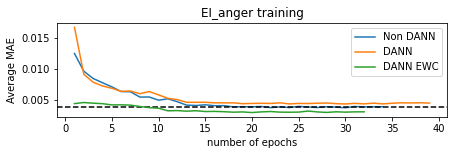

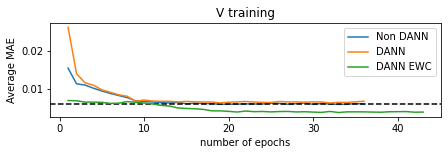

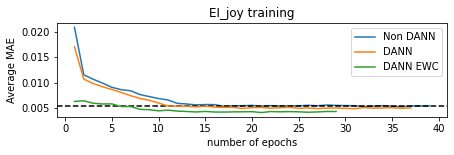

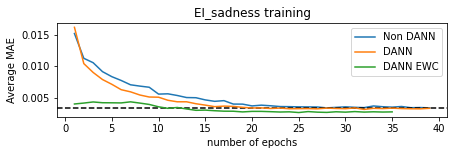

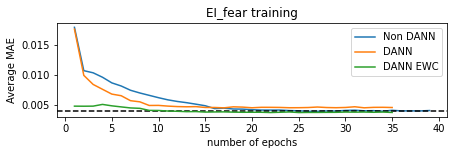

In [167]:
# Training Loss plots

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.axhline(y = list1_to_plot[-1], linestyle = "dashed", color ='black')
  list2_to_plot = dict_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['train_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend()
  plt.title(name + " training")
  plt.show()



In [168]:
len(range(50,101))

51

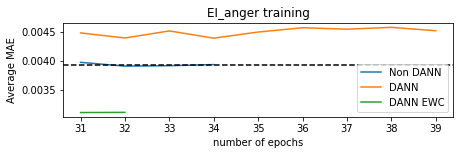

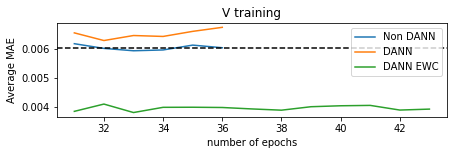

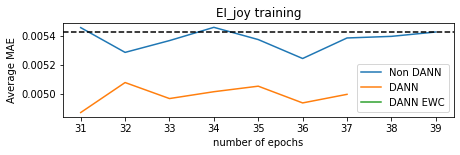

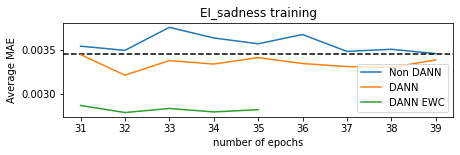

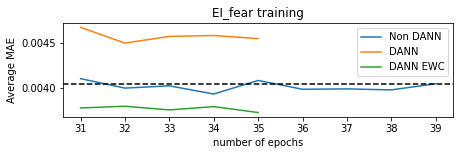

In [169]:
# Training Loss plots x onwards
x = 30

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['train_losses']
  plt.plot(range(x+1,len(list1_to_plot)+1),list1_to_plot[x:], label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.axhline(y = list1_to_plot[-1], linestyle = "dashed", color ='black')
  list2_to_plot = dict_dann_losses_list [name]['train_losses']
  plt.plot(range(x+1,len(list2_to_plot)+1),list2_to_plot[x:], label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['train_losses']
  plt.plot(range(x+1,len(list3_to_plot)+1),list3_to_plot[x:], label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend()
  plt.title(name + " training")
  plt.show()



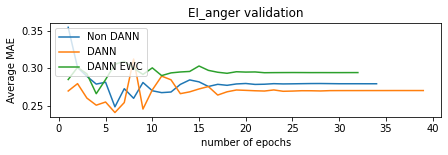

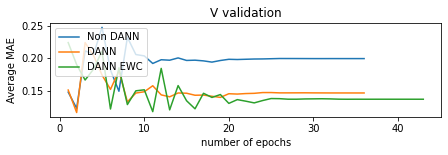

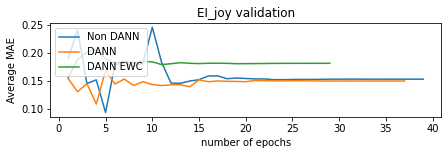

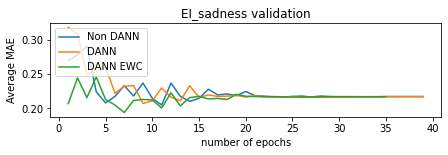

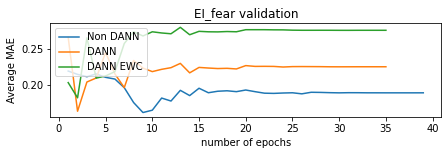

In [170]:
# Validation Loss plots

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list2_to_plot = dict_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['val_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend(loc = 'upper left')
  plt.title(name +" validation")

  plt.show()


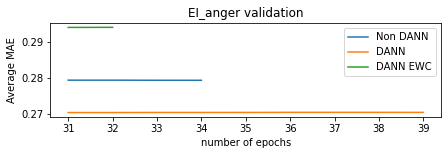

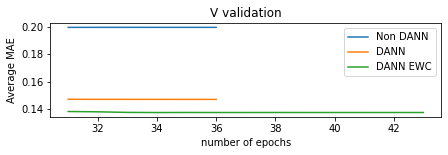

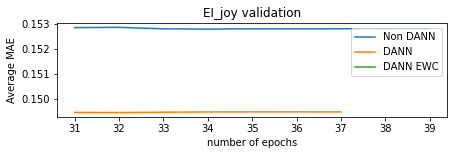

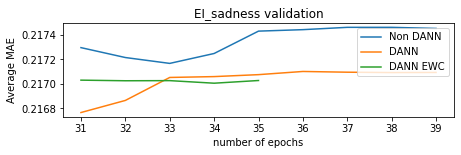

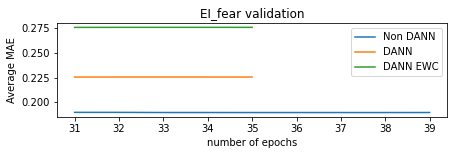

In [171]:
# Validation Loss plots after x
x = 30

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['val_losses']
  plt.plot(range(x+1,len(list1_to_plot)+1),list1_to_plot[x:], label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list2_to_plot = dict_dann_losses_list [name]['val_losses']
  plt.plot(range(x+1,len(list2_to_plot)+1),list2_to_plot[x:], label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['val_losses']
  plt.plot(range(x+1,len(list3_to_plot)+1),list3_to_plot[x:], label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend(loc = 'upper right')
  plt.title(name +" validation")

  plt.show()

# Equality Evaluation using Equity Evaluation Corpus

## Loading Evaluation Data
format `[ID	Sentence	Template	Person	Gender	Race Emotion	Emotion word]`

In [172]:
data_EEC = TASK1.EEC['eec']
df_EEC = pd.read_csv(data_EEC)
df_EEC.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


## Creating evalution function (includes pre-processing)

In [173]:
## padding function : adds padding / truncates to max size
def pad_or_truncate(some_list, target_len = MAX_SIZE, pad_idx = PAD_IDX):
    return some_list[:target_len] + [pad_idx]*(target_len - len(some_list))

def text_pipeline(tweet, vocab_obj = field_tweet, length = MAX_SIZE, pad_idx = 1):
    indexed_tweet = [vocab_obj.vocab.__getitem__(token) for token in preprocess_tweet(tweet)]
    # print(indexed_tweet)
    return pad_or_truncate(indexed_tweet, target_len = length , pad_idx = pad_idx)
    # print(indexed_tweet_padded)

## Loading model

In [174]:
dict_non_dann_model_saved ={}
dict_dann_model_saved ={}
dict_dann_ewc_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  dict_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_dann_"+EMBEDDING_TO_BE_USED+".pt"  
  dict_dann_ewc_model_saved[name] = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  print(name)
print(dict_non_dann_model_saved)
print(dict_dann_model_saved)

EI_anger
V
EI_joy
EI_sadness
EI_fear
{'EI_anger': 'EI_anger_25_01_non_dann_glove_gn.pt', 'V': 'V_25_01_non_dann_glove_gn.pt', 'EI_joy': 'EI_joy_25_01_non_dann_glove_gn.pt', 'EI_sadness': 'EI_sadness_25_01_non_dann_glove_gn.pt', 'EI_fear': 'EI_fear_25_01_non_dann_glove_gn.pt'}
{'EI_anger': 'EI_anger_25_01_dann_glove_gn.pt', 'V': 'V_25_01_dann_glove_gn.pt', 'EI_joy': 'EI_joy_25_01_dann_glove_gn.pt', 'EI_sadness': 'EI_sadness_25_01_dann_glove_gn.pt', 'EI_fear': 'EI_fear_25_01_dann_glove_gn.pt'}


In [175]:
### Loading Model


# dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}
# dict_dann_model_saved[name] = model_name
# dict_non_dann_model_saved[name]= model_name

dict_loaded_models = {}
for name in list_name:
  non_dann_model_name = dict_non_dann_model_saved[name]
  dann_model_name = dict_dann_model_saved[name]
  dann_ewc_model_name = dict_dann_ewc_model_saved[name]
  # print(non_dann_model_name,dann_model_name)
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_non_dann.eval()

  loaded_model_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann.eval()

  loaded_model_dann_ewc = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann_ewc.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_ewc_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann_ewc.eval()

  dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann,"dann_ewc": loaded_model_dann_ewc}

print(dict_loaded_models.keys())

EI_anger 4689
V 4320
EI_joy 4653
EI_sadness 4859
EI_fear 5544
dict_keys(['EI_anger', 'V', 'EI_joy', 'EI_sadness', 'EI_fear'])


In [176]:
from torch.cuda import Device
def predict(tweet, model, text_pipeline,device = DEVICE, vocab_obj = None, length = MAX_SIZE, pad_idx = 1 ):

  with torch.no_grad():
    # tweet_tensor = torch.tensor(text_pipeline(tweet)).unsqueeze(0).to(device)
    tweet_tensor = torch.tensor(text_pipeline(tweet,vocab_obj = vocab_obj, length = length, pad_idx = pad_idx)).unsqueeze(0).to(device)
    output = model(tweet_tensor)
    return output[0].item()

In [177]:
# i = random.randint(0,len(df_EEC))
# tweet_example = df_EEC['Sentence'][i]
# loaded_model_device = 'cpu'
# loaded_model = dict_loaded_models['EI_anger']['dann'].to(loaded_model_device)
# print(predict(tweet_example, loaded_model,text_pipeline, device= loaded_model_device))

## Creating Sentence pairs (as per SEMVAL18 paper)

In [178]:
dict_f_m_noun_phrase = {'she':'he', 
            'her':'him',
            'this woman':'this man',
            'this girl':'this boy',
            'my sister' : 'my brother',
            'my daughter' : 'my son',
            'my wife': 'my husband',
            'my girlfriend':'my boyfriend',
            'my mother':'my father',
            'my aunt':'my uncle',
            'my mom': 'my dad'
            }

name_male = ['Alonzo','Jamel','Alphonse','Jerome','Leroy','Torrance','Darnell','Lamar','Malik','Terrence','Adam','Harry','Josh','Roger','Alan','Frank','Justin','Ryan','Andrew','Jack'] 
name_female = ['Nichelle','Shereen','Ebony','Latisha','Shaniqua','Jasmine','Tanisha','Tia','Lakisha','Latoya','Amanda','Courtney','Heather','Melanie','Katie','Betsy','Kristin','Nancy','Stephanie','Ellen']


In [179]:
list_unique_template = list(df_EEC['Template'].dropna().unique())
# print(list_unique_template)
list_emotion_word = list(df_EEC['Emotion word'].unique()) # contains nan also
# print(list_emotion_word)
list_gender = list(df_EEC['Gender'].dropna().unique())
# print(list_gender)
list_person = list(df_EEC['Person'].unique())   
# print(list_person)

In [180]:
# print(list_emotion_word) # nan exists in the emotion word list

In [181]:
# Template - F - M Noun Phrases chunks (Checked again 3012)

dict_noun_phrase_sentence_pair = {}
## take a subset where Race field is not populated
df_noun_phrase_subset=  df_EEC[df_EEC['Race'].isna()] ## includes values which do not have Race 
count = 0
# print(len(df_noun_phrase_subset),df_noun_phrase_subset.head())
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_noun_phrase_subset['Template']== template)
    condition_2 = (df_noun_phrase_subset['Emotion word'] == emotion_word)
    condition_3 = (df_noun_phrase_subset['Gender'] == 'female')
    condition_4 = (df_noun_phrase_subset['Gender'] == 'male')
    list_female = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_noun_phrase_sentence_pair[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_noun_phrase_subset['Emotion word'].isna())
      list_female_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_noun_phrase_sentence_pair[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1

print(count)
# print(len(dict_noun_phrase_sentence_pair),"dict_noun_phrase_sentence_pair............ \n",dict_noun_phrase_sentence_pair)                                                                                                                                                                                                                                         


144


In [182]:
# Template -  ORIGINAL TRYING 3012

dict_original_sentence_pair = {}
count = 0

for template in list_unique_template:
  # list_noun_phrase_female = []                                  
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC['Template']== template)
    condition_2 = (df_EEC['Emotion word'].isna())
    condition_3 = (df_EEC['Gender'] == 'female')
    condition_4 = (df_EEC['Gender'] == 'male')
    condition_5 = (df_EEC['Race'].notnull())
    condition_6 = (df_EEC['Race'].isna())
    condition_9 = (df_EEC['Emotion word'].notnull())
    list_noun_phrase_female = []
    list_noun_phrase_male = []
    if pd.isnull(emotion_word):
      
      # Check for named people - no emotion
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1 
      # Check for noun phrases - emotion
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

    else: # emotion is present
      # Check for named people - with emotion
      list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1
      # Check for noun phrases - with emotion
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 
      

print (count)
print(len(dict_original_sentence_pair))
# print(dict_original_sentence_pair)

      
# print(len(dict_original_sentence_pair),"dict_original_sentence_pair............ \n",dict_original_sentence_pair)

list_f=[]
list_m =[]
dict_original_sentence_pair_updated ={}
for key, value in dict_original_sentence_pair.items():
  list_f = list_f + value[0]
  list_m = list_m + value[1]
  # list_f.append(value[0])
  # list_m.append(value[1])

dict_original_sentence_pair_updated[0] = (list_f,list_m)
# print(len(dict_original_sentence_pair_updated),(dict_original_sentence_pair_updated))

288
288


In [183]:
# for Named people (Checked again 3012)

dict_list_named_sentence_pairs ={}
df_EEC_subset = df_EEC.dropna(subset = ['Race']) ## removes values which do not have Race 
print(len(df_EEC_subset))

count = 0
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC_subset['Template']== template)
    condition_2 = (df_EEC_subset['Emotion word'] == emotion_word)
    condition_3 = (df_EEC_subset['Gender'] == 'female')
    condition_4 = (df_EEC_subset['Gender'] == 'male')
    list_female = df_EEC_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_EEC_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    # print(len(list_female), len(list_male))
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_list_named_sentence_pairs[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_EEC_subset['Emotion word'].isna())
      list_female_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_list_named_sentence_pairs[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1
        
print (count)
# print(len(dict_list_named_sentence_pairs))
# print(dict_list_named_sentence_pairs)

5760
144


In [184]:
# for no emotion people (Checked again 3012)

dict_no_emotion_sentence_pairs ={}
count = 0


for template in list_unique_template:
  # list_noun_phrase_female = []
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    if pd.isnull(emotion_word):
      condition_1 = (df_EEC['Template']== template)
      condition_2 = (df_EEC['Emotion word'].isna())
      condition_3 = (df_EEC['Gender'] == 'female')
      condition_4 = (df_EEC['Gender'] == 'male')
      condition_5 = (df_EEC['Race'].notnull())
      condition_6 = (df_EEC['Race'].isna())

      # Check for named people
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_female,list_male)
        count = count + 1 

      # Check for noun phrases
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

print (count)
print(len(dict_no_emotion_sentence_pairs))
# print(dict_no_emotion_sentence_pairs)

8
8


In [185]:
## No EMOTION 1 sentence pair

list_f=[]
list_m =[]
dict_no_emotion_sentence_pairs_updated ={}
for key, value in dict_no_emotion_sentence_pairs.items():
  list_f = list_f + value[0]
  list_m = list_m + value[1]


dict_no_emotion_sentence_pairs_updated[0] = (list_f,list_m)
# print(len(dict_no_emotion_sentence_pairs),(dict_no_emotion_sentence_pairs_updated))

In [186]:
# print(dict_list_named_sentence_pairs[0][0],"\n",dict_list_named_sentence_pairs[0][1])

In [187]:
# ANGER ONLY, SADNESS ONLY, FEAR ONLY, JOY ONLY 1 Sentence pair

dict_emotion_sentence_pairs ={}


for emotion in df_EEC['Emotion'].dropna().unique().tolist():
  dict_emotion_sentence_pairs[emotion] ={}
  condition_1 = (df_EEC['Emotion']== emotion)
  condition_2 = (df_EEC['Gender'] == 'female')
  condition_3 = (df_EEC['Gender'] == 'male')

  list_female = df_EEC[(condition_1) & (condition_2)]['Sentence'].to_list()
  list_male = df_EEC[(condition_1) & (condition_3)]['Sentence'].to_list()
  dict_emotion_sentence_pairs[emotion][0]=(list_female,list_male)


print(dict_emotion_sentence_pairs.keys())

dict_keys(['anger', 'sadness', 'fear', 'joy'])


## Two Sample t- test

In [188]:
# f ='She feels angry.'
# m ='He feels angry.'
# f_indices = text_pipeline(f)
# m_indices = text_pipeline(m)
# f_value = predict(f, loaded_model,text_pipeline,device= loaded_model_device)
# m_value = predict(m, loaded_model,text_pipeline,device= loaded_model_device)
# print(f_value,m_value)
# stats.ttest_rel(f_value, m_value)

In [189]:
# Function for t-test processing

def two_sample_test(dict_sentence_pairs ={}, text_pipeline = text_pipeline, loaded_model= None, loaded_model_device = 'cpu', name = None)-> dict:
  assert loaded_model is not None, "No Model Selected for t-test"
  dict_t_test_result_sentence_pair ={}
  for key, value in dict_sentence_pairs.items():

    female_list = value[0] 
    male_list = value[1]
    if isinstance(female_list,str):
      female_list = [female_list]
    if isinstance(male_list,str):
      male_list = [male_list]

    assert len(female_list) == len(male_list), f"Different lengths: Lengths of female list is {len(female_list)} and male list is {len(male_list)}"
    
    # INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
    PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]


    female_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in female_list]
    male_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in male_list]

    # print(female_list_indices)
    # print("type check for all elements ",all(isinstance(x, (int, float)) for x in female_list_indices))
    # print("length ",len(set(female_list_indices)))

    # female_list_indices = [text_pipeline(tweet_example) for tweet_example in female_list]
    # male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

    female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX ) for sentence in female_list]
    male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for sentence in male_list]
    # female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
    # male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]

    # print(female_list_output)
    # print("type check for all elements ",all(isinstance(x, (int, float)) for x in female_list_output))
    # print("length ",len(set(female_list_output)))

    t_test_result = stats.ttest_rel(female_list_output, male_list_output)
    dict_t_test_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
  # print(dict_t_test_result_sentence_pair)
  return dict_t_test_result_sentence_pair



In [190]:
dict_loaded_models.keys()

dict_keys(['EI_anger', 'V', 'EI_joy', 'EI_sadness', 'EI_fear'])

In [191]:
# type(dict_emotion_sentence_pairs['joy'].values())
for name, value in dict_emotion_sentence_pairs['joy'].items():
  print (len(value[0]),len(value[1]) )
  # print( value[0])


1050 1050


In [192]:
lm = dict_loaded_models['EI_joy']['dann_ewc']

In [193]:
t_test_level_2 = two_sample_test(dict_sentence_pairs = dict_emotion_sentence_pairs['joy'] ,
                                 text_pipeline = text_pipeline, 
                                 loaded_model = lm, 
                                 loaded_model_device = 'cpu',
                                 name = 'EI_joy')
# t_test_level_2

In [194]:
t_test_level_2 = two_sample_test(dict_sentence_pairs = dict_no_emotion_sentence_pairs_updated,
                                 text_pipeline = text_pipeline, 
                                 loaded_model = lm, 
                                 loaded_model_device = 'cpu',
                                 name = 'EI_joy')
# t_test_level_2

In [195]:
# dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann}

# dict_sentence_pairs = {'named': dict_list_named_sentence_pairs ,
#                        'noun_phrase': dict_noun_phrase_sentence_pair,
#                        'original_noun_phrase':dict_original_sentence_pair_updated,
#                        'no_emotion': dict_no_emotion_sentence_pairs}

dict_sentence_pairs = {
    # 'named': dict_list_named_sentence_pairs ,
    # 'noun_phrase': dict_noun_phrase_sentence_pair,
    'original_noun_phrase':dict_original_sentence_pair_updated,
    'no_emotion': dict_no_emotion_sentence_pairs_updated,
    'only_anger': dict_emotion_sentence_pairs['anger'],
    'only_sadness' : dict_emotion_sentence_pairs['sadness'],
    'only_fear' : dict_emotion_sentence_pairs['fear'],
    'only_joy' : dict_emotion_sentence_pairs['joy']
                       }

dict_t_test = {}
for name, model_dict in dict_loaded_models.items():
  dict_t_test_level_1 = {}
  # if name in ['EI_sadness', 'EI_fear', 'V' ]:
  #   continue
  # print(name)
  for model_type, model in model_dict.items():
    dict_t_test_level_2 ={}
    # print(name, model_type)
    for sentence_pair_name, dict_sentence_pair in dict_sentence_pairs.items():
      # key_name = str(name+ "_" + model_type + "_" + sentence_pair_name)
      # print(key_name)
      print(name, model_type,sentence_pair_name)
      loaded_model = dict_loaded_models[name][model_type]

      dict_t_test_level_2[sentence_pair_name] = two_sample_test(dict_sentence_pairs = dict_sentence_pair ,
                                        text_pipeline = text_pipeline, 
                                        loaded_model = loaded_model, 
                                        loaded_model_device = 'cpu',
                                        name = name)
      print(sentence_pair_name, dict_t_test_level_2[sentence_pair_name] )
    dict_t_test_level_1[model_type] = dict_t_test_level_2
    print(model_type,sentence_pair_name, dict_t_test_level_1[model_type])
  dict_t_test[name] = dict_t_test_level_1
  print(name, model_type,sentence_pair_name, dict_t_test[name])
  
print(dict_t_test)
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


EI_anger non_dann original_noun_phrase
original_noun_phrase {0: (-8.21991589304734, 2.6656696293983567e-16, -0.0024860529780939555)}
EI_anger non_dann no_emotion
no_emotion {0: (-0.6709817320020984, 0.5035324536172374, -0.0011902184536060068)}
EI_anger non_dann only_anger
only_anger {0: (-3.3121694622001003, 0.0009573420799677718, -0.002058902538958074)}
EI_anger non_dann only_sadness
only_sadness {0: (-4.485453031023433, 8.078068960267045e-06, -0.0026886534832772924)}
EI_anger non_dann only_fear
only_fear {0: (-4.188362779276424, 3.045774188905939e-05, -0.00260966132084528)}
EI_anger non_dann only_joy
only_joy {0: (-4.470590870609551, 8.649011313672334e-06, -0.0027350899435225062)}
non_dann only_joy {'original_noun_phrase': {0: (-8.21991589304734, 2.6656696293983567e-16, -0.0024860529780939555)}, 'no_emotion': {0: (-0.6709817320020984, 0.5035324536172374, -0.0011902184536060068)}, 'only_anger': {0: (-3.3121694622001003, 0.0009573420799677718, -0.002058902538958074)}, 'only_sadness': {

In [196]:
# list_sentence_pairs = ['named','noun_phrase']
# dict_t_test ={}
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


In [197]:
# dict_t_test.items()

In [198]:
# dict_t_test_noun_phrase_sentence_pair = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
# dict_t_test_named_sentence_pairs = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')

In [199]:
# dict_result_named_sentence_pair ={}

# for key, value in dict_list_named_sentence_pairs.items():
#   female_list = value[0]
#   male_list = value[1]
#   female_list_indices = [ text_pipeline(tweet_example)for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_named_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print((dict_result_named_sentence_pair))

In [200]:
# #without named people
# dict_result_sentence_pair ={}
# # for key, value in dict_sentence_pair:
# #   if len(value[0])
# print(len(dict_sentence_pair))

# for key, value in dict_sentence_pair.items():
#   female_list = [value[0]]
#   male_list = [value[1]]
#   # if len(female_list)!=len(male_list):
#   #   print("key:", key)
#   #   print(female_list,"\n",male_list)
#   #   print(len(female_list),"-",len(male_list))
#   #   print(text_pipeline(female_list[0]),"\n",text_pipeline(male_list[0]))
#   #   break

#   female_list_indices = [ text_pipeline(tweet_example) for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example) for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print(dict_result_sentence_pair)

# Analysis of results (based on semval paper)

In [201]:
# dict_t_test_noun_phrase_sentence_pair
# dict_t_test_named_sentence_pairs

In [202]:
# len(dict_t_test_noun_phrase_sentence_pair),len(dict_t_test_named_sentence_pairs)

In [203]:
def analysis_t_test(dict_t_test_sentence_pairs, threshold = 0.05):
  list_output =[]
  for key, test_output in dict_t_test_sentence_pairs.items():
    significant=True
    t_statistic = test_output[0]
    p_value = test_output[1]
    f_m_diff = test_output[2]
    if (float(p_value) > float(threshold) or float(p_value) == float(threshold)):
      significant=False
      category = 'f_equals_m'
    else:
      significant=True
      
      if f_m_diff > 0:
        category='f_high_m_low'
      else:
        category = 'f_low_m_high' 
    list_output.append([key,t_statistic,p_value,significant,f_m_diff,category])
    
  df_columns = ['key','t_statistic','p_value', 'significant','delta','category']
  df_output = pd.DataFrame(list_output, columns = df_columns)


  list_category = list(df_output['category'].unique())
  list_statistics =[]
  for category in list_category:
    df_temp = df_output[df_output['category']==category]
    average = df_temp['delta'].mean()
    # print(category,len(df_temp), average)
    list_statistics.append([category,len(df_temp), average])
  
  # calculating for all starts
  if len(list_statistics) > 1: # All makes sense when there are more than 1 categories
    all_average = df_output['delta'].mean()
    list_statistics.append(["All",len(df_output), all_average])
  # calculating for all ends

  df_statistics = pd.DataFrame(list_statistics, columns = ['category', 'num_pairs','average_difference'])
  return df_statistics


# print(analysis_t_test(dict_t_test_noun_phrase_sentence_pair))
# print(analysis_t_test(dict_t_test_named_sentence_pairs))


In [204]:
{'EI_anger': {
    'non_dann': {
        'original_noun_phrase': {
            0: (0.1998956871564016, 0.8415904073105785, 3.9207107490946136e-05)}}, 
    'dann': {
        'original_noun_phrase': {
            0: (-3.055498578204014, 0.002288182511007486, -0.0005662351846695279)}}}, 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513, 0.4856923878774828, 0.0001477275302426695)}}, 'dann': {'original_noun_phrase': {0: (2.6524225900747918, 0.008079505029578445, 0.0012747823571165329)}}}, 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802, 0.057935765936073504, -0.0004837316667868352)}}, 'dann': {'original_noun_phrase': {0: (-4.093950892599476, 4.476596480751689e-05, -0.0010545446744395504)}}}, 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935, 0.210942010423521, -0.0002394391637708937)}}, 'dann': {'original_noun_phrase': {0: (-6.649931016376002, 4.1525086430524637e-11, -0.0012206101997030983)}}}, 'V': {'non_dann': {'original_noun_phrase': {0: (-0.6159244491387837, 0.5380417924786083, -0.00019533265795973476)}}, 'dann': {'original_noun_phrase': {0: (-1.5534286604033418, 0.12054065128353071, -0.0005289117702179658)}}}}


{'EI_anger': {'non_dann': {'original_noun_phrase': {0: (0.1998956871564016,
     0.8415904073105785,
     3.9207107490946136e-05)}},
  'dann': {'original_noun_phrase': {0: (-3.055498578204014,
     0.002288182511007486,
     -0.0005662351846695279)}}},
 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513,
     0.4856923878774828,
     0.0001477275302426695)}},
  'dann': {'original_noun_phrase': {0: (2.6524225900747918,
     0.008079505029578445,
     0.0012747823571165329)}}},
 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802,
     0.057935765936073504,
     -0.0004837316667868352)}},
  'dann': {'original_noun_phrase': {0: (-4.093950892599476,
     4.476596480751689e-05,
     -0.0010545446744395504)}}},
 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935,
     0.210942010423521,
     -0.0002394391637708937)}},
  'dann': {'original_noun_phrase': {0: (-6.649931016376002,
     4.1525086430524637e-11,
     -0.001220610199

In [205]:
dict_statistics={}
for name, dict_model_type_sentence_pair in dict_t_test.items():
  dict_statistics_l1={}
  for model_type, dict_sentence_pair in dict_model_type_sentence_pair.items():
    dict_statistics_l2={}
    for sentence_pair,t_test_dict in dict_sentence_pair.items():
      df_statistics = analysis_t_test(t_test_dict, threshold = 0.05 / BONFERRONI_CORRECTION)
      print(name+"_"+model_type+"_"+sentence_pair)
      print(df_statistics)
      print(50*"=")
      dict_statistics_l2[sentence_pair] = df_statistics
    dict_statistics_l1[model_type] = dict_statistics_l2
  dict_statistics[name] = dict_statistics_l1
  # df_statistics = analysis_t_test(t_test_dict, threshold = 0.05)
  # dict_statistics[model_type_sentence_pair_name] = df_statistics

EI_anger_non_dann_original_noun_phrase
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002486
EI_anger_non_dann_no_emotion
     category  num_pairs  average_difference
0  f_equals_m          1            -0.00119
EI_anger_non_dann_only_anger
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002059
EI_anger_non_dann_only_sadness
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002689
EI_anger_non_dann_only_fear
       category  num_pairs  average_difference
0  f_low_m_high          1            -0.00261
EI_anger_non_dann_only_joy
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002735
EI_anger_dann_original_noun_phrase
       category  num_pairs  average_difference
0  f_high_m_low          1             0.00651
EI_anger_dann_no_emotion
       category  num_pairs  average_difference
0  f_high_m_low          1            0.010246
EI_anger_

In [206]:
dict_statistics['EI_joy']['dann_ewc']




{'original_noun_phrase':        category  num_pairs  average_difference
 0  f_high_m_low          1            0.003092,
 'no_emotion':      category  num_pairs  average_difference
 0  f_equals_m          1            0.001989,
 'only_anger':        category  num_pairs  average_difference
 0  f_high_m_low          1            0.002993,
 'only_sadness':        category  num_pairs  average_difference
 0  f_high_m_low          1            0.003279,
 'only_fear':        category  num_pairs  average_difference
 0  f_high_m_low          1            0.003136,
 'only_joy':        category  num_pairs  average_difference
 0  f_high_m_low          1            0.003085}

In [207]:
col_name = ['name', 'sentence_pair_name', 'model_name', 'results' ]
df_nice_results = pd.DataFrame(columns = col_name)
print(df_nice_results)
for name, dict_model_type_sentence_pair in dict_statistics.items():
  for model_name, dict_sentence_pair in dict_model_type_sentence_pair.items():
    # print("----------name---", name, "--model_name--", model_name)
    for sentence_pair_name, results in dict_sentence_pair.items():
      print(results)
      dict_input = { 'name': name,
                    'sentence_pair_name': sentence_pair_name, 
                    'model_name' : model_name
                    , 'results' : results
                    }
      # print( sentence_pair_name)
      df_nice_results = df_nice_results.append(dict_input, ignore_index=True)
# df_nice_results

Empty DataFrame
Columns: [name, sentence_pair_name, model_name, results]
Index: []
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002486
     category  num_pairs  average_difference
0  f_equals_m          1            -0.00119
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002059
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002689
       category  num_pairs  average_difference
0  f_low_m_high          1            -0.00261
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002735
       category  num_pairs  average_difference
0  f_high_m_low          1             0.00651
       category  num_pairs  average_difference
0  f_high_m_low          1            0.010246
       category  num_pairs  average_difference
0  f_high_m_low          1            0.006274
       category  num_pairs  average_difference
0  f_high_m_low          1  

In [208]:
print(df_nice_results.groupby(['name','sentence_pair_name','model_name']))

In [209]:
df_nice_results.to_csv("results.csv")

In [210]:
df_nice_results.sort_values(['sentence_pair_name','name'])

,name,sentence_pair_name,model_name,results
1,EI_anger,no_emotion,non_dann,category num_pairs average_difference 0...
7,EI_anger,no_emotion,dann,category num_pairs average_difference...
13,EI_anger,no_emotion,dann_ewc,category num_pairs average_difference...
73,EI_fear,no_emotion,non_dann,category num_pairs average_difference...
79,EI_fear,no_emotion,dann,category num_pairs average_difference 0...
...,...,...,...,...
60,EI_sadness,original_noun_phrase,dann,category num_pairs average_difference 0...
66,EI_sadness,original_noun_phrase,dann_ewc,category num_pairs average_difference...
18,V,original_noun_phrase,non_dann,category num_pairs average_difference 0...
24,V,original_noun_phrase,dann,category num_pairs average_difference...


# Nice Results

In [211]:
for name in df_nice_results['name'].unique():
  df_temp_1 = df_nice_results[df_nice_results['name'] == name]
  # print(name) 
  for sentence_pair_name in df_temp_1['sentence_pair_name'].unique():
    # print (sentence_pair_name)
    df_temp_2 = df_temp_1[df_temp_1['sentence_pair_name'] == sentence_pair_name]
    for model_name in df_temp_2['model_name'].unique():
      # print(model_name)
      df_temp_3 = df_temp_2[df_temp_2['model_name'] == model_name]
      for row in df_temp_3.iterrows():
        if "only" in sentence_pair_name:
          value_name = name.split("_")[-1]
          value_sentence_pair = sentence_pair_name.split("_")[-1]
          if (value_name == value_sentence_pair):
            print(name+"_"+sentence_pair_name+"_"+model_name + "_"+EMBEDDING_TO_BE_USED)
            print(row[1]['results'])
            print(50*"=")
        else:
          # print(name+"_"+model_name+"_"+sentence_pair_name)
          print(name+"_"+sentence_pair_name+"_"+model_name + "_"+EMBEDDING_TO_BE_USED)
          print(row[1]['results'])
          print(50*"=")
      # # print(name+"_"+model_name+"_"+sentence_pair_name)
      # df_temp_4 = pd.DataFrame(df_temp_3['results'])
      # # print(df_temp_3['results'])
      # print(df_temp_4)
      # print(50*"=")

EI_anger_original_noun_phrase_non_dann_glove_gn
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002486
EI_anger_original_noun_phrase_dann_glove_gn
       category  num_pairs  average_difference
0  f_high_m_low          1             0.00651
EI_anger_original_noun_phrase_dann_ewc_glove_gn
       category  num_pairs  average_difference
0  f_high_m_low          1             0.00517
EI_anger_no_emotion_non_dann_glove_gn
     category  num_pairs  average_difference
0  f_equals_m          1            -0.00119
EI_anger_no_emotion_dann_glove_gn
       category  num_pairs  average_difference
0  f_high_m_low          1            0.010246
EI_anger_no_emotion_dann_ewc_glove_gn
       category  num_pairs  average_difference
0  f_high_m_low          1            0.007556
EI_anger_only_anger_non_dann_glove_gn
       category  num_pairs  average_difference
0  f_low_m_high          1           -0.002059
EI_anger_only_anger_dann_glove_gn
       category  num_pai

In [212]:
overall_result = pd.DataFrame()
for sentence_pair_name in df_nice_results['sentence_pair_name'].unique():
    df_temp_1 = df_nice_results[df_nice_results['sentence_pair_name'] == sentence_pair_name]
    if "only" in sentence_pair_name:
        for name in df_nice_results['name'].unique():
            value_name = name.split("_")[-1]
            value_sentence_pair = sentence_pair_name.split("_")[-1]
            if (value_name == value_sentence_pair): 
                df_temp_2 = df_temp_1[df_temp_1['name'] == name]
                print(f'---Like name {value_name} for Like sentence pair {value_sentence_pair}---')
                res = df_temp_2.pivot_table(index = ['sentence_pair_name', 'name'], columns = 'model_name', values ='results', aggfunc ='first').reset_index()
    else:
        res = df_temp_1.pivot_table(index = ['sentence_pair_name', 'name'], columns = 'model_name', values ='results', aggfunc ='first').reset_index()
    overall_result = overall_result.append(res, ignore_index = True)


---Like name anger for Like sentence pair anger---
---Like name sadness for Like sentence pair sadness---
---Like name fear for Like sentence pair fear---
---Like name joy for Like sentence pair joy---


In [213]:
overall_result = overall_result[['sentence_pair_name','name','non_dann','dann','dann_ewc']]
overall_result

model_name,sentence_pair_name,name,non_dann,dann,dann_ewc
0,original_noun_phrase,EI_anger,category num_pairs average_difference...,category num_pairs average_difference...,category num_pairs average_difference...
1,original_noun_phrase,EI_fear,category num_pairs average_difference...,category num_pairs average_difference...,category num_pairs average_difference...
2,original_noun_phrase,EI_joy,category num_pairs average_difference...,category num_pairs average_difference 0...,category num_pairs average_difference...
3,original_noun_phrase,EI_sadness,category num_pairs average_difference...,category num_pairs average_difference 0...,category num_pairs average_difference...
4,original_noun_phrase,V,category num_pairs average_difference 0...,category num_pairs average_difference...,category num_pairs average_difference...
5,no_emotion,EI_anger,category num_pairs average_difference 0...,category num_pairs average_difference...,category num_pairs average_difference...
6,no_emotion,EI_fear,category num_pairs average_difference...,category num_pairs average_difference 0...,category num_pairs average_difference...
7,no_emotion,EI_joy,category num_pairs average_difference 0...,category num_pairs average_difference 0...,category num_pairs average_difference 0...
8,no_emotion,EI_sadness,category num_pairs average_difference 0...,category num_pairs average_difference 0...,category num_pairs average_difference 0...
9,no_emotion,V,category num_pairs average_difference 0...,category num_pairs average_difference 0...,category num_pairs average_difference...


In [214]:
file_name = "result_" + EMBEDDING_TO_BE_USED + "_" + str(time.strftime("%d_%m")) + ".csv" 
#name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 

# overall_result.to_csv("overall_result.csv")
overall_result.to_csv(file_name)

In [215]:
# for sentence_pair_name in df_nice_results['sentence_pair_name'].unique():
#   df_temp_1 = df_nice_results[df_nice_results['sentence_pair_name'] == sentence_pair_name]
#   df_x = df_temp_1.groupby(['name'])
#   df = pd.DataFrame()
#   df = df_x.get_group(name)
#   print(df)
#   results_df = df.set_index(['sentence_pair_name' ,'name','model_name'], drop=True).unstack('model_name')

#   # results_df = df.pivot_table( 'results', ['sentence_pair_name' ,'name'])
#   # results_df = df.pivot_table( 'results',['sentence_pair_name' ,'name'] ,'model_name')
#   print (results_df)
#   # for name in df_nice_results['name'].unique():
#   #   df = pd.DataFrame()
#   #   df = df_x.get_group(name)
#   #   print(type(df))
#   #   print(df)
#   break

  
  # df = pd.DataFrame()
  # df = df_x.first()
  # print(type(df))
  # print(df)
  # # print(df_x)
  # break
  # for name in df_nice_results['name'].unique():
  #   df_temp_2 = df_temp_1[df_temp_1['name'] == name]
  #   print(df_temp_2)
  #   for model_name in df_temp_2['model_name'].unique():
    
  # break